In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(230, 243959)

In [4]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]#
[col for col in data_loaded.columns if 'Color' in col and 'Slope' in col]

['Sum ColorSlope visitExposureTime > 19 HealpixSlicer',
 'Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer']

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'Y1,u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'Y1,g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'Y1,r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'Y1,i',
    'best18k Parallax fiveSigmaDepth, filter, seeingFwhmGeom, ra_pi_amp, dec_pi_amp HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            #'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
            #'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            #'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Sum ColorSlope visitExposureTime > 19 HealpixSlicer': 'color slope',
            "Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer": "2day\ncolor slope",
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'Y1,u': '',
         'Y1,g': '',
         'Y1,r': '',
         'Y1,i': '',
         'color slope': 'N',
         '2day\ncolor slope': 'N',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan',
           'u', 'g', 'r', 'i', 'z', 'y']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean N gaps in %s at %ihr in top 18k Gaps_%ihr %s band HealpixSlicer'% (filtername, times, times, filtername)] = 'gaps %s %i' % (filtername, times)
        #gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [6]:
#data['KNe single model'] # data['KNe ZTF simple']

In [7]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [8]:
mag_data

g          i          r          u  \
all_long_v3.4_10yrs          26.711776  26.410069  26.898572  25.306253   
baseline_v2.0_10yrs          26.733479  26.218659  26.755971  25.818916   
baseline_v2.1_10yrs          26.736248  26.252054  26.781543  25.751969   
baseline_v2.2_10yrs          26.753646  26.290929  26.835430  25.724699   
baseline_v3.0_10yrs          26.688123  26.264600  26.818287  25.668262   
...                                ...        ...        ...        ...   
weather_cloudso35v3.4_10yrs  26.765863  26.461740  26.936502  25.311023   
weather_cloudso36v3.4_10yrs  26.782824  26.458285  26.939210  25.320909   
weather_cloudso4v3.4_10yrs   26.823834  26.479794  26.976399  25.365712   
weather_cloudso6v3.4_10yrs   26.821514  26.491849  26.973728  25.364518   
weather_cloudso8v3.4_10yrs   26.790266  26.478523  26.947715  25.339956   

                                     y          z  
all_long_v3.4_10yrs          24.800546  25.717667  
baseline_v2.0_10yrs          24.762720  25.510379  
baseline_v2.1_10yrs          24.728145  25.486640  
baseline_v2.2_10yrs          24.782743  25.581317  
baseline_v3.0_10yrs          24.756955  25.524781  
...                                ...        ...  
weather_cloudso35v3.4_10yrs  24.801142  25.752581  
weather_cloudso36v3.4_10yrs  24.804274  25.760733  
weather_cloudso4v3.4_10yrs   24.823256  25.770120  
weather_cloudso6v3.4_10yrs   24.837915  25.780059  
weather_cloudso8v3.4_10yrs   24.812671  25.769788  

[230 rows x 6 columns]

In [9]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

N SN COSMOS  N SN ECDFS    N SN EDFS  \
all_long_v3.4_10yrs           987.315354  851.049522  1515.003534   
baseline_v2.0_10yrs           638.253284  586.826209   974.231557   
baseline_v2.1_10yrs           548.479625  545.669910   875.981802   
baseline_v2.2_10yrs           708.239238  685.202422  1067.553931   
baseline_v3.0_10yrs           955.159293  799.584601  1266.961769   
...                                  ...         ...          ...   
weather_cloudso35v3.4_10yrs   931.201159  809.597913  1379.044260   
weather_cloudso36v3.4_10yrs   971.367562  773.848626  1391.251789   
weather_cloudso4v3.4_10yrs    999.605374  851.867808  1640.412837   
weather_cloudso6v3.4_10yrs    999.888886  871.682608  1701.222170   
weather_cloudso8v3.4_10yrs    969.834234  856.870331  1467.846362   

                             N SN ELAISS1  N SN XMM_LSS  zlim COSMOS  \
all_long_v3.4_10yrs            798.808515    827.798189     0.516848   
baseline_v2.0_10yrs            684.401547    611.229060     0.503926   
baseline_v2.1_10yrs            636.634918    520.071105     0.496150   
baseline_v2.2_10yrs            674.561648    611.247120     0.493897   
baseline_v3.0_10yrs            688.808879    726.491723     0.503734   
...                                   ...           ...          ...   
weather_cloudso35v3.4_10yrs    777.300267    734.947313     0.548710   
weather_cloudso36v3.4_10yrs    827.270250    832.244000     0.550022   
weather_cloudso4v3.4_10yrs     855.877115    930.847858     0.537376   
weather_cloudso6v3.4_10yrs     898.212537    929.571852     0.546925   
weather_cloudso8v3.4_10yrs     775.027988    802.991071     0.552646   

                             zlim ECDFS  zlim EDFS  zlim ELAISS1  \
all_long_v3.4_10yrs            0.565924   0.504254      0.513191   
baseline_v2.0_10yrs            0.485978   0.481621      0.508870   
baseline_v2.1_10yrs            0.484905   0.474738      0.501027   
baseline_v2.2_10yrs            0.495572   0.466223      0.488264   
baseline_v3.0_10yrs            0.521961   0.464010      0.500330   
...                                 ...        ...           ...   
weather_cloudso35v3.4_10yrs    0.535488   0.496629      0.510424   
weather_cloudso36v3.4_10yrs    0.544726   0.502587      0.489120   
weather_cloudso4v3.4_10yrs     0.559896   0.512214      0.515553   
weather_cloudso6v3.4_10yrs     0.562375   0.508507      0.522198   
weather_cloudso8v3.4_10yrs     0.556612   0.486633      0.497771   

                             zlim XMM_LSS  ...  Kne EDFS  Kne ELAISS1  \
all_long_v3.4_10yrs              0.513753  ...     574.0        482.0   
baseline_v2.0_10yrs              0.490990  ...     365.0        423.0   
baseline_v2.1_10yrs              0.480094  ...     373.0        384.0   
baseline_v2.2_10yrs              0.484132  ...     425.0        370.0   
baseline_v3.0_10yrs              0.484669  ...     428.0        405.0   
...                                   ...  ...       ...          ...   
weather_cloudso35v3.4_10yrs      0.497228  ...     572.0        479.0   
weather_cloudso36v3.4_10yrs      0.505490  ...     537.0        503.0   
weather_cloudso4v3.4_10yrs       0.518643  ...     609.0        524.0   
weather_cloudso6v3.4_10yrs       0.504127  ...     671.0        540.0   
weather_cloudso8v3.4_10yrs       0.499293  ...     604.0        536.0   

                             Kne WFD  Kne XMM_LSS  N COSMOS  N ECDFS  N EDFS  \
all_long_v3.4_10yrs            414.0        450.0   18662.5  10470.0  6686.0   
baseline_v2.0_10yrs            298.0        317.0    8937.5   9264.0  5497.0   
baseline_v2.1_10yrs            289.0        325.0    8900.0   9166.5  5506.0   
baseline_v2.2_10yrs            327.0        304.0    9853.0   9663.0  6150.0   
baseline_v3.0_10yrs            339.0        340.0   18716.5  10606.5  6668.0   
...                              ...          ...       ...      ...     ...   
weather_cloudso35v3.4_10yrs    423.0        417.0   19240.5   9827.0  6115.0   
w

In [10]:
gaps_data

gaps u 3  gaps u 7  gaps u 24  gaps g 3  \
all_long_v3.4_10yrs          0.113256  0.059635   3.816851  0.174243   
baseline_v2.0_10yrs          0.559565  0.096983   2.681121  0.501515   
baseline_v2.1_10yrs          0.601110  0.097077   2.961440  0.621392   
baseline_v2.2_10yrs          0.633655  0.187066   3.622465  0.399776   
baseline_v3.0_10yrs          0.257192  0.257425   3.984706  0.213736   
...                               ...       ...        ...       ...   
weather_cloudso35v3.4_10yrs  0.184455  0.101366   4.178393  0.200214   
weather_cloudso36v3.4_10yrs  0.211498  0.118851   3.977713  0.198116   
weather_cloudso4v3.4_10yrs   0.195692  0.122488   3.865342  0.212011   
weather_cloudso6v3.4_10yrs   0.187066  0.117825   4.292488  0.187066   
weather_cloudso8v3.4_10yrs   0.194806  0.165571   4.092973  0.200121   

                             gaps g 7  gaps g 24  gaps r 3  gaps r 7  \
all_long_v3.4_10yrs          0.157411   4.636639  4.032732  3.550473   
baseline_v2.0_10yrs          0.060381   4.151443  2.579755  0.452371   
baseline_v2.1_10yrs          0.080291   4.104024  2.708024  0.389565   
baseline_v2.2_10yrs          0.051569   4.466172  1.834849  0.314636   
baseline_v3.0_10yrs          0.363687   3.787056  1.069054  1.779876   
...                               ...        ...       ...       ...   
weather_cloudso35v3.4_10yrs  0.127617   4.756609  1.779736  1.525202   
weather_cloudso36v3.4_10yrs  0.152889   4.558959  1.885485  1.503847   
weather_cloudso4v3.4_10yrs   0.163613   4.511773  1.980230  1.521378   
weather_cloudso6v3.4_10yrs   0.148366   4.941064  1.819089  1.489253   
weather_cloudso8v3.4_10yrs   0.158857   4.620693  1.823985  1.554064   

                             gaps r 24  gaps i 3  gaps i 7  gaps i 24  \
all_long_v3.4_10yrs          20.404905  3.397445  2.949783  19.411060   
baseline_v2.0_10yrs          17.055252  2.086213  0.422810  15.289504   
baseline_v2.1_10yrs          18.103231  2.217187  0.366019  16.026064   
baseline_v2.2_10yrs          19.672775  1.433580  0.276449  16.984520   
baseline_v3.0_10yrs          20.989882  1.293328  1.973516  18.047932   
...                                ...       ...       ...        ...   
weather_cloudso35v3.4_10yrs  25.156292  1.703269  1.066023  21.343778   
weather_cloudso36v3.4_10yrs  25.169907  1.534527  0.999067  21.828041   
weather_cloudso4v3.4_10yrs   25.140859  1.616030  0.850329  21.654404   
weather_cloudso6v3.4_10yrs   26.936355  1.793957  1.107801  22.493262   
weather_cloudso8v3.4_10yrs   25.330582  1.669558  1.101273  22.026624   

                             gaps z 3  gaps z 7  gaps z 24  gaps y 3  \
all_long_v3.4_10yrs          2.885812  2.296219  15.708677  1.075069   
baseline_v2.0_10yrs          2.832937  0.465706  18.134005  2.181890   
baseline_v2.1_10yrs          3.008206  0.484776  18.327179  2.477409   
baseline_v2.2_10yrs          2.238075  0.408775  20.773395  1.377629   
baseline_v3.0_10yrs          1.569590  1.366578  22.387886  0.725976   
...                               ...       ...        ...       ...   
weather_cloudso35v3.4_10yrs  1.225020  0.806873  19.403087  1.471068   
weather_cloudso36v3.4_10yrs  1.119690  0.803516  19.293794  1.410967   
weather_cloudso4v3.4_10yrs   1.192847  0.779550  19.186739  1.470975   
weather_cloudso6v3.4_10yrs   1.402993  1.002798  20.438663  1.598219   
weather_cloudso8v3.4_10yrs   1.250711  0.813167  19.220917  1.425514   

                             gaps y 7  gaps y 24  
all_long_v3.4_10yrs          0.377069  13.291463  
baseline_v2.0_10yrs          0.218119  10.919662  
baseline_v2.1_10yrs          0.206229  10.257798  
baseline_v2.2_10yrs          0.186833   8.640323  
baseline_v3.0_10yrs          0.211312   9.392083  
...                               ...        ...  
weather_cloudso35v3.4_10yrs  0.617616  16.143983  
weather_cloudso36v3.4_10yrs  0.581200  16.243717  
weather_cloudso4v3.4_10yrs   0.610202  16.145568  
weather_cloudso6v3.4_10yrs   0.646431  17.48258

In [11]:
#runs = [run for run in data.index ]
#ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
#                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
#fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

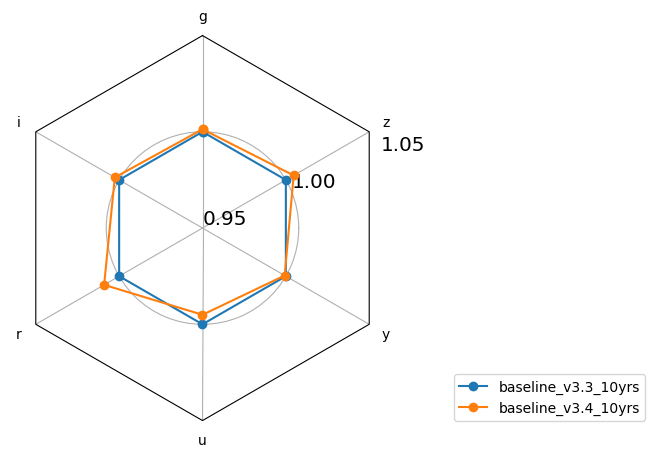

In [12]:
runs = ['baseline_v3.3_10yrs', 'baseline_v3.4_10yrs' ]
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.3_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [13]:
#runs = [ run for run in data.index if '3.4' in run]
#ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
#                 mag_cols = mag_cols, norm_run='initial_v3.4_10yrs')
#fig, ax = radar(ndata, legend=True, rgrids=[0.90, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

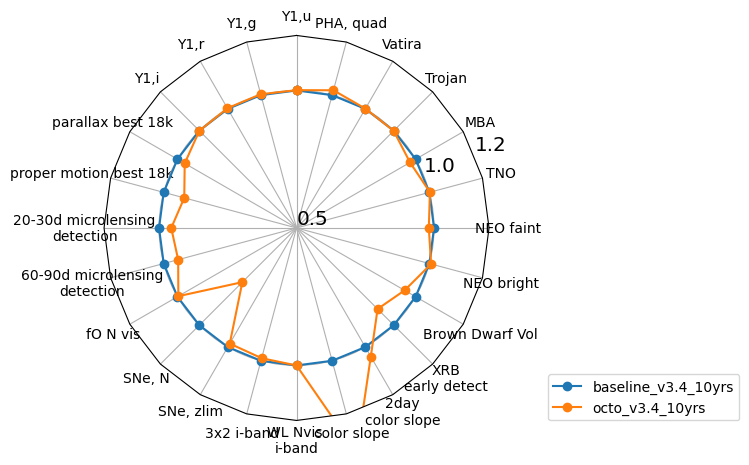

In [14]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index  if 'octo' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

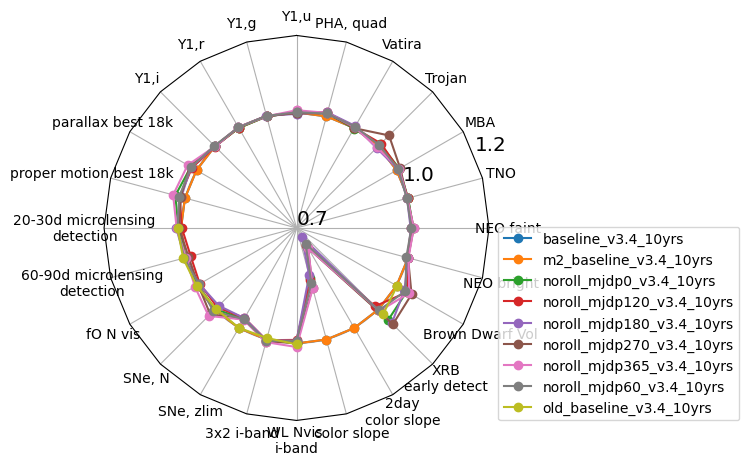

In [15]:
runs = [run for run in data.index if 'baseline_v3.4' in run or 'noroll' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.7, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

In [16]:
ndata

Y1,u      Y1,g      Y1,r      Y1,i  \
baseline_v3.4_10yrs        1.000000  1.000000  1.000000  1.000000   
m2_baseline_v3.4_10yrs     1.000000  1.000000  1.000000  1.000000   
noroll_mjdp0_v3.4_10yrs    1.000000  1.000000  1.000000  1.000000   
noroll_mjdp120_v3.4_10yrs  0.999147  1.001247  1.001241  0.998885   
noroll_mjdp180_v3.4_10yrs  0.996304  1.001746  1.002234  0.999257   
noroll_mjdp270_v3.4_10yrs  0.998010  1.001372  1.002109  1.000372   
noroll_mjdp365_v3.4_10yrs  1.005829  1.000249  1.002358  0.999505   
noroll_mjdp60_v3.4_10yrs   1.000426  1.001372  1.001737  1.001610   
old_baseline_v3.4_10yrs         NaN       NaN       NaN       NaN   

                           parallax best 18k  proper motion best 18k  \
baseline_v3.4_10yrs                 1.000000                1.000000   
m2_baseline_v3.4_10yrs              1.000000                1.000000   
noroll_mjdp0_v3.4_10yrs             1.017121                1.025960   
noroll_mjdp120_v3.4_10yrs           1.013450                1.014127   
noroll_mjdp180_v3.4_10yrs           1.016769                1.009974   
noroll_mjdp270_v3.4_10yrs           1.020230                1.011630   
noroll_mjdp365_v3.4_10yrs           1.026508                1.031840   
noroll_mjdp60_v3.4_10yrs            1.016371                1.015627   
old_baseline_v3.4_10yrs                  NaN                     NaN   

                           20-30d microlensing\ndetection  \
baseline_v3.4_10yrs                                1.0000   
m2_baseline_v3.4_10yrs                             1.0000   
noroll_mjdp0_v3.4_10yrs                            1.0070   
noroll_mjdp120_v3.4_10yrs                          0.9979   
noroll_mjdp180_v3.4_10yrs                          1.0126   
noroll_mjdp270_v3.4_10yrs                          1.0044   
noroll_mjdp365_v3.4_10yrs                          1.0114   
noroll_mjdp60_v3.4_10yrs                           1.0089   
old_baseline_v3.4_10yrs                            1.0091   

                           60-90d microlensing\ndetection  fO N vis    SNe, N  \
baseline_v3.4_10yrs                                1.0000  1.000000  1.000000   
m2_baseline_v3.4_10yrs                             1.0000  1.000000  1.000000   
noroll_mjdp0_v3.4_10yrs                            0.9971  0.996328  0.998202   
noroll_mjdp120_v3.4_10yrs                          0.9845  0.990208  0.991169   
noroll_mjdp180_v3.4_10yrs                          1.0007  0.991432  0.985667   
noroll_mjdp270_v3.4_10yrs                          0.9906  0.995104  1.017104   
noroll_mjdp365_v3.4_10yrs                          0.9974  1.004896  1.023114   
noroll_mjdp60_v3.4_10yrs                           1.0024  0.992656  1.005677   
old_baseline_v3.4_10yrs                            1.0048  1.000000  0.996447   

                           ...  2day\ncolor slope  XRB\nearly detect  \
baseline_v3.4_10yrs        ...           1.000000           1.000000   
m2_baseline_v3.4_10yrs     ...           1.000000           1.000000   
noroll_mjdp0_v3.4_10yrs    ...           0.756650           1.037200   
noroll_mjdp120_v3.4_10yrs  ...           0.749745           0.987763   
noroll_mjdp180_v3.4_10yrs  ...           0.727019           1.049927   
noroll_mjdp270_v3.4_10yrs  ...           0.760027           1.053842   
noroll_mjdp365_v3.4_10yrs  ...           0.760643           1.004895   
noroll_mjdp60_v3.4_10yrs   ...           0.747078           1.002937   
old_baseline_v3.4_10yrs    ...                NaN           1.017621   

                           Brown Dwarf Vol  NEO bright  NEO faint       TNO  \
baseline_v3.4_10yrs               1.000000      1.0000   1.000000  1.000000   
m2_baseline_v3.4_10yrs            1.000000      1.0000   1.000000  1.000000   
noroll_mjdp0_v3.4_10yrs           1.030536      0.9976   1.003205  0.999807   
noroll_mjdp120_v3.4_10yrs         1.032804      0.9976   0.998147  0.999741   
noroll_mjdp180_v3.4_10yrs         1.023537      1.0004   0.996325  0.997154   
no

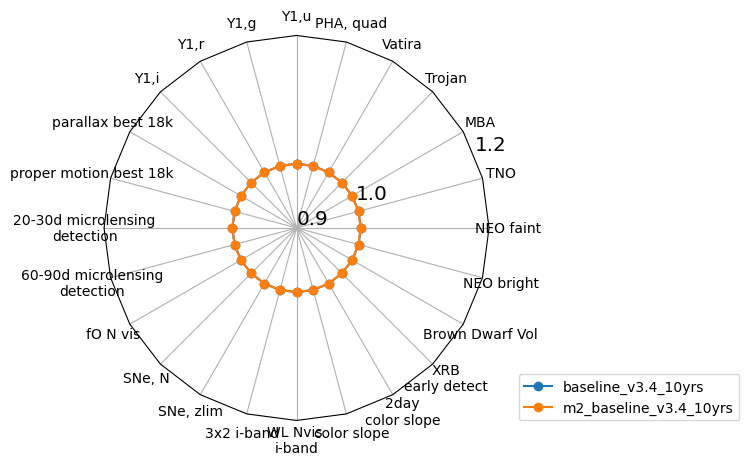

In [17]:
# Look at difference between cluster and Apple chips
runs = ['baseline_v3.4_10yrs', 'm2_baseline_v3.4_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

In [18]:
# One snap
#runs = ['baseline_v3.4_10yrs', 'onesnap_v3.4_10yrs' ]
#ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
#                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
#fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

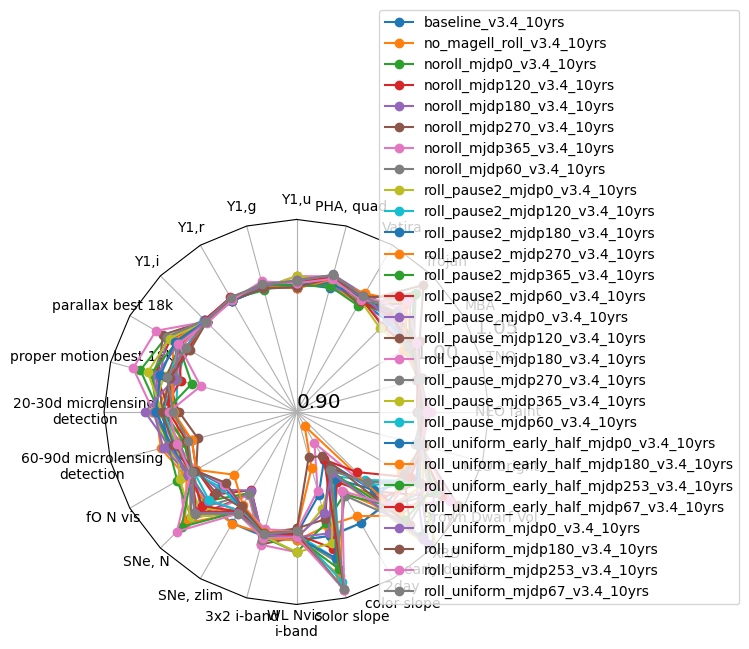

In [19]:
# various rolling
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'roll' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.90, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

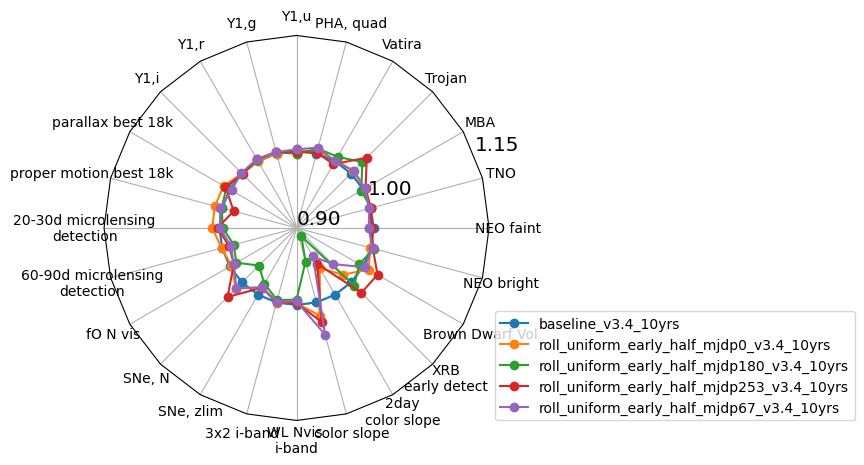

In [20]:
# various rolling
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'roll' in run and 'half' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.15], bbox_to_anchor=(1.95, 0))

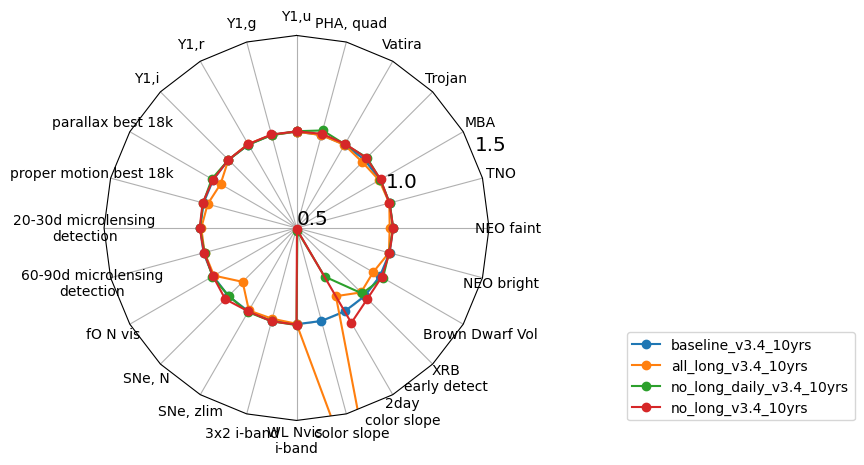

In [21]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'long' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.5], bbox_to_anchor=(1.95, 0))

In [22]:


times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs', 'baseline_v3.4_10yrs', 'roll_uniform_mjdp0_v3.4_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data



Y1,u      Y1,g      Y1,r      Y1,i  \
retro_baseline_v2.0_10yrs      0.893276  0.949104  0.960964  0.958616   
baseline_v2.0_10yrs            0.955776  0.981594  0.994441  0.997035   
baseline_v2.1_10yrs            0.948661  0.984188  0.996912  0.999012   
baseline_v2.2_10yrs            0.871233  0.914268  0.993947  0.998023   
baseline_v3.0_10yrs            0.813058  0.901174  0.993823  0.999135   
baseline_v3.2_10yrs            0.973633  0.982335  0.996170  0.995800   
baseline_v3.3_10yrs            0.987305  0.992712  0.997529  0.996294   
baseline_v3.4_10yrs            0.981306  0.990364  0.995553  0.997529   
roll_uniform_mjdp0_v3.4_10yrs  0.984096  0.992094  0.998147  0.998023   

                               parallax best 18k  proper motion best 18k  \
retro_baseline_v2.0_10yrs               0.804328                0.176701   
baseline_v2.0_10yrs                     0.791058                0.184088   
baseline_v2.1_10yrs                     0.806910                0.188258   
baseline_v2.2_10yrs                     0.792958                0.186345   
baseline_v3.0_10yrs                     0.792666                0.185683   
baseline_v3.2_10yrs                     0.782518                0.185369   
baseline_v3.3_10yrs                     0.753823                0.179042   
baseline_v3.4_10yrs                     0.752625                0.177617   
roll_uniform_mjdp0_v3.4_10yrs           0.748572                0.177806   

                               20-30d microlensing\ndetection  \
retro_baseline_v2.0_10yrs                              0.0878   
baseline_v2.0_10yrs                                    0.3119   
baseline_v2.1_10yrs                                    0.3141   
baseline_v2.2_10yrs                                    0.3268   
baseline_v3.0_10yrs                                    0.3232   
baseline_v3.2_10yrs                                    0.3437   
baseline_v3.3_10yrs                                    0.3817   
baseline_v3.4_10yrs                                    0.3653   
roll_uniform_mjdp0_v3.4_10yrs                          0.3834   

                               60-90d microlensing\ndetection  fO N vis  \
retro_baseline_v2.0_10yrs                              0.1568     848.0   
baseline_v2.0_10yrs                                    0.4348     839.0   
baseline_v2.1_10yrs                                    0.4319     838.0   
baseline_v2.2_10yrs                                    0.4487     830.0   
baseline_v3.0_10yrs                                    0.4528     795.0   
baseline_v3.2_10yrs                                    0.4869     805.0   
baseline_v3.3_10yrs                                    0.5233     811.0   
baseline_v3.4_10yrs                                    0.5179     817.0   
roll_uniform_mjdp0_v3.4_10yrs                          0.5207     815.0   

                                      SNe, N  ...  2day\ncolor slope  \
retro_baseline_v2.0_10yrs       97124.012102  ...          1072605.0   
baseline_v2.0_10yrs             99302.532220  ...          1283741.0   
baseline_v2.1_10yrs             99294.339899  ...          1277085.0   
baseline_v2.2_10yrs            112802.099640  ...          1408541.0   
baseline_v3.0_10yrs            109475.798536  ...          1528234.0   
baseline_v3.2_10yrs            123176.659086  ...          1436743.0   
baseline_v3.3_10yrs            152910.228661  ...          1492778.0   
baseline_v3.4_10yrs            151098.440513  ...          1559032.0   
roll_uniform_mjdp0_v3.4_10yrs  152832.096559  ...          1488421.0   

                               XRB\nearly detect  Brown Dwarf Vol  NEO bright  \
retro_baseline_v2.0_10yrs                  720.0    179634.826127      0.9048   
baseline_v2.0_10yrs                       1882.0    168080.497664      0.9294   
baseline_v2.1_10yrs                       1918.0    163809.598961      0.9286   
baseline_v2.2_10yrs                       1921.0    172447.199022      0.9304   
baseline_v3.0_1

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_23041/3763499284.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


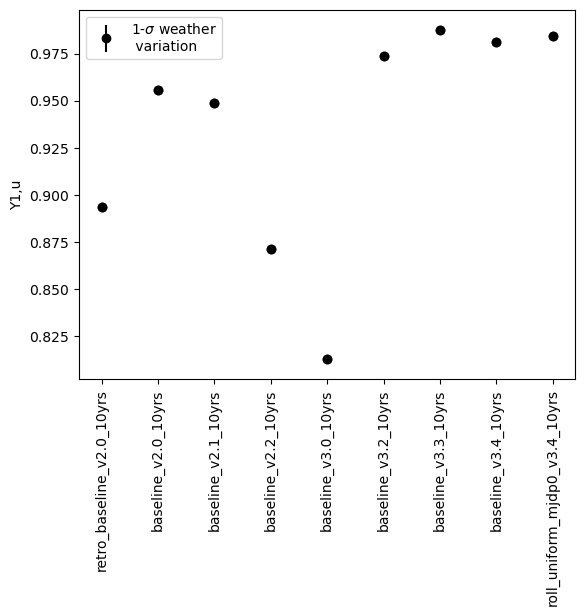

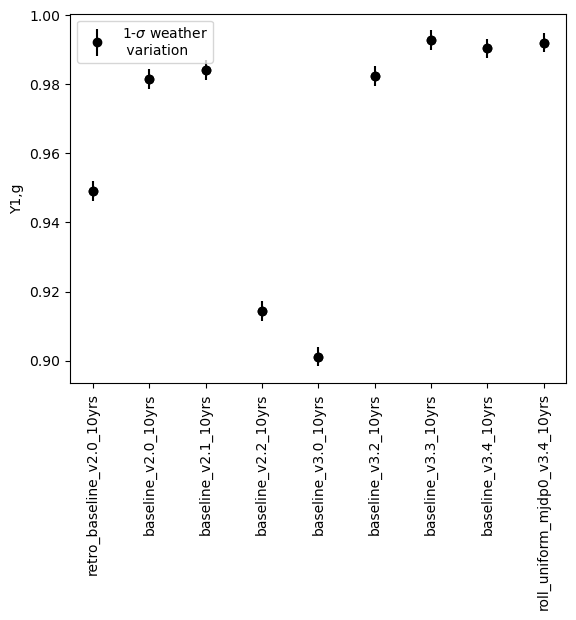

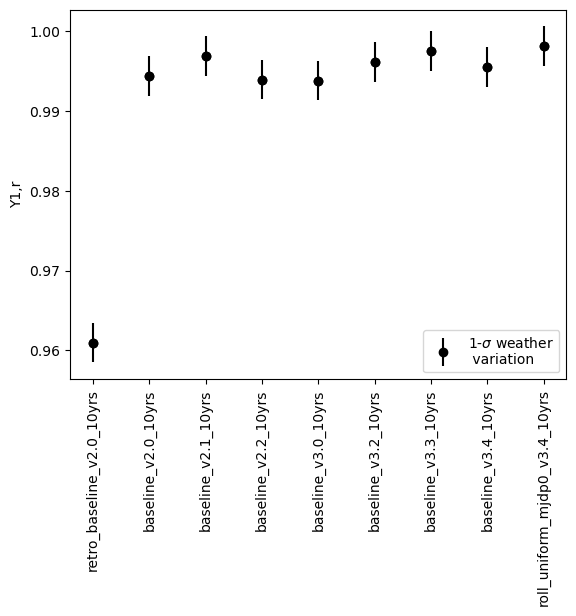

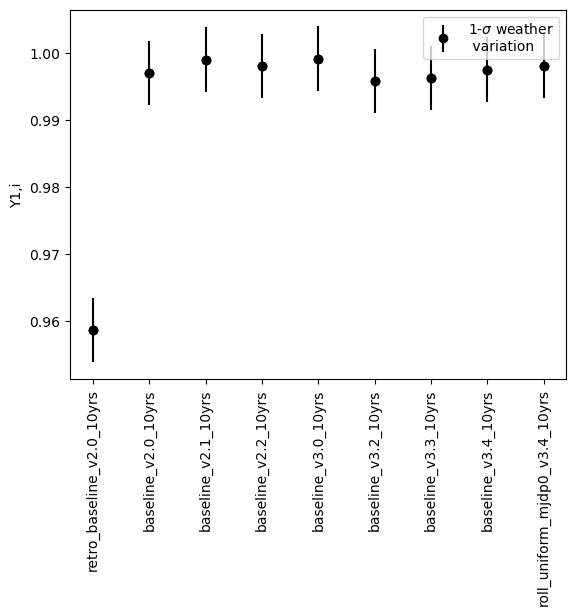

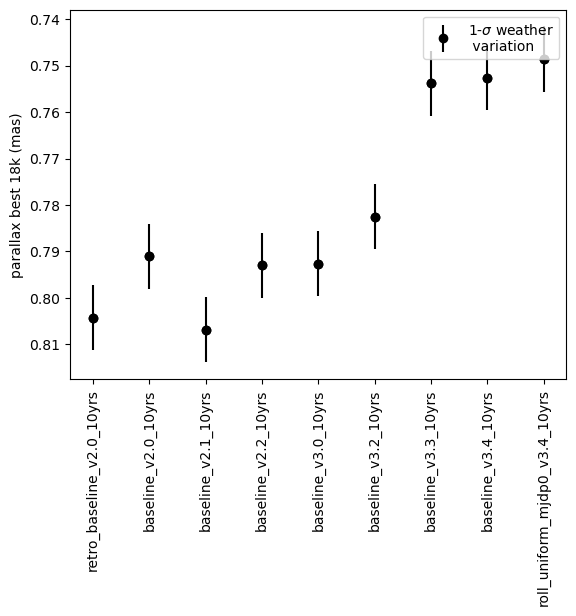

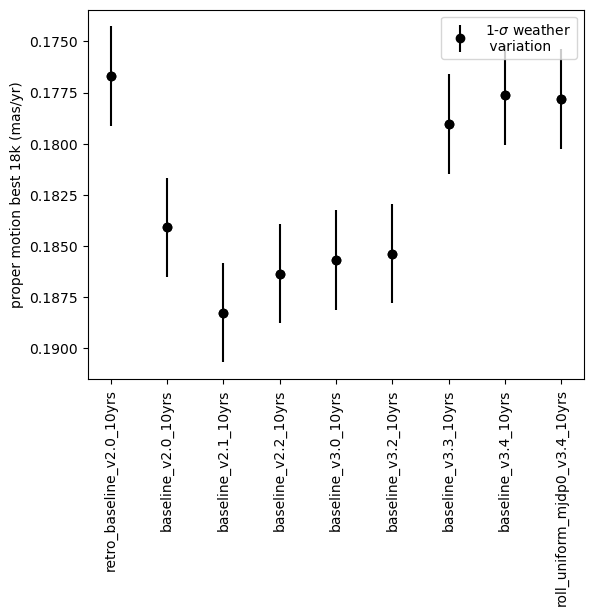

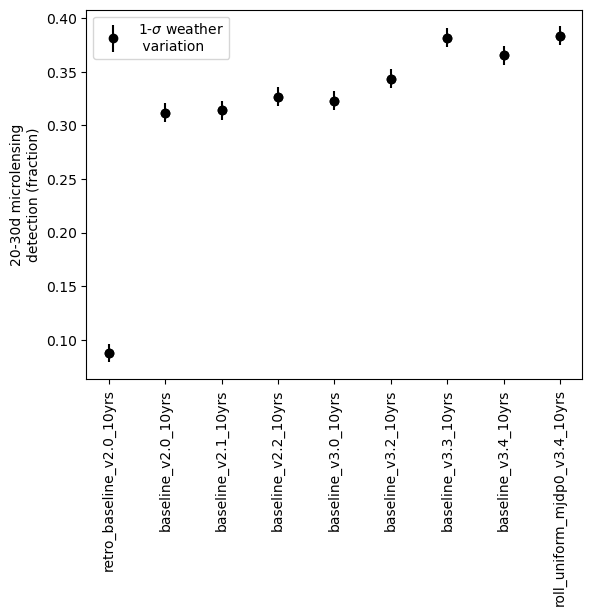

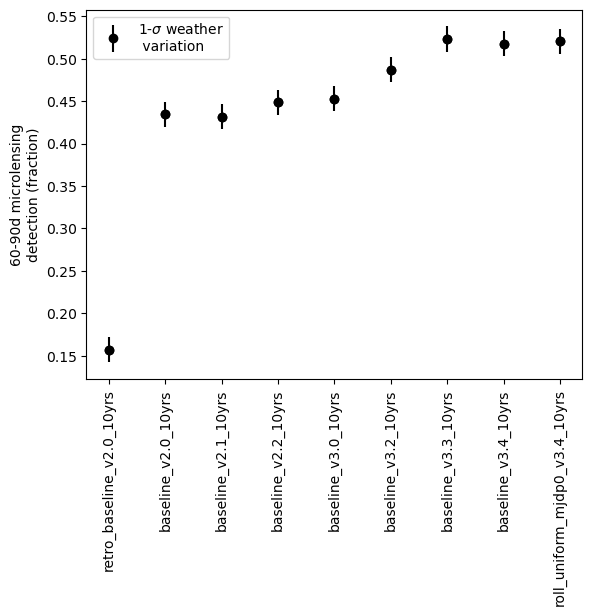

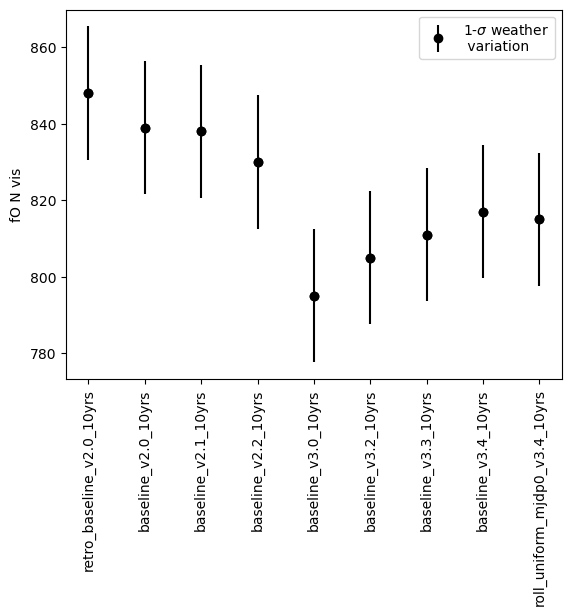

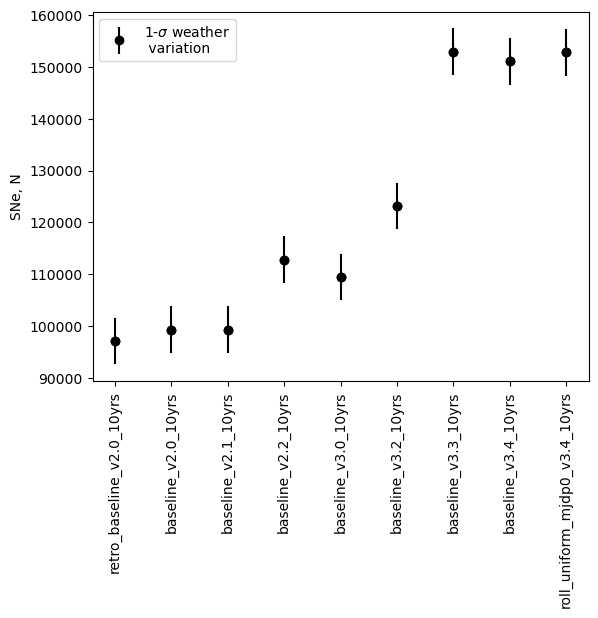

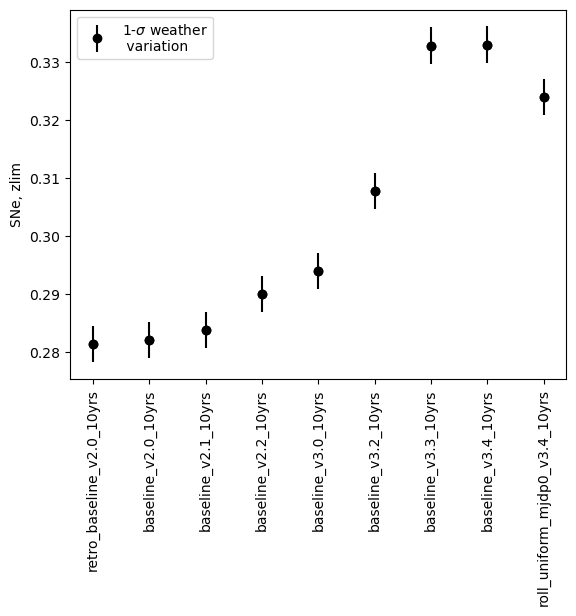

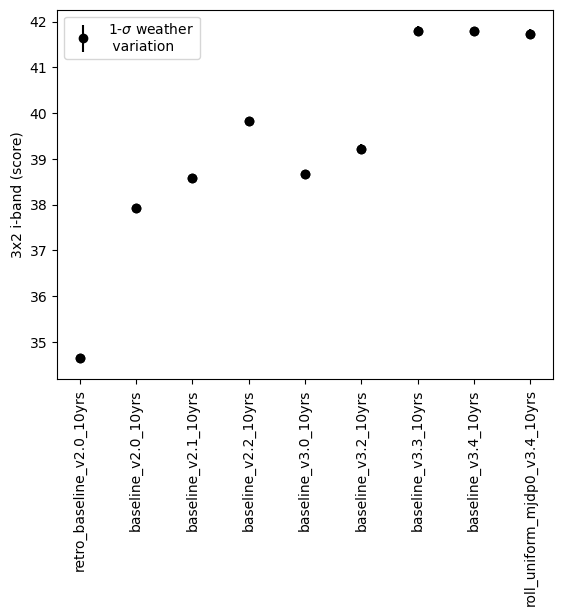

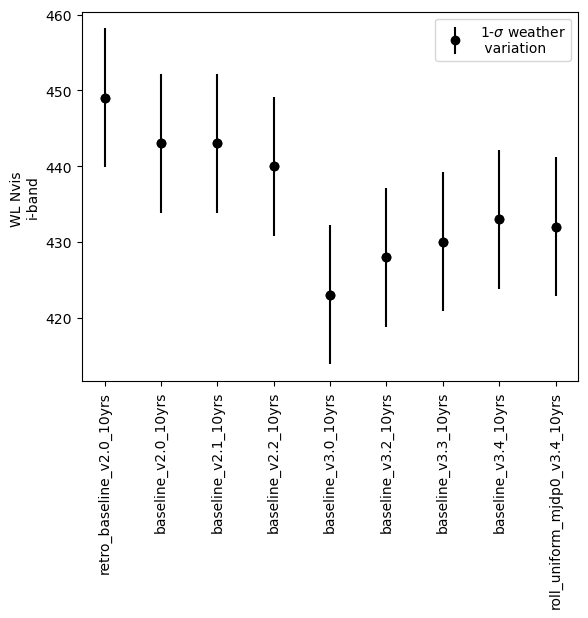

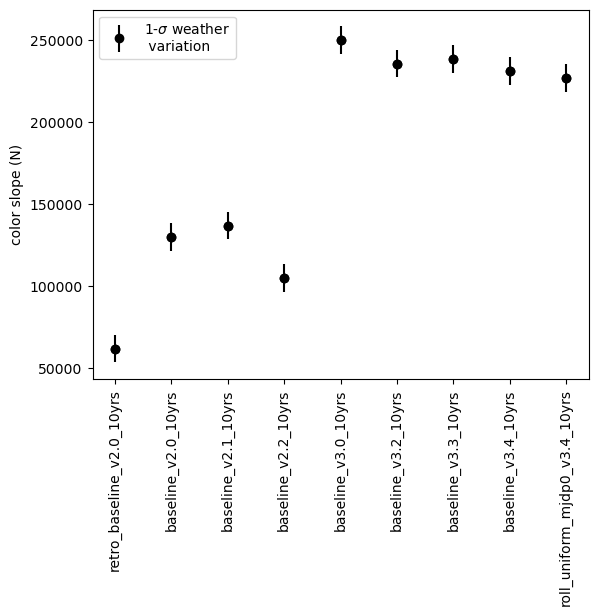

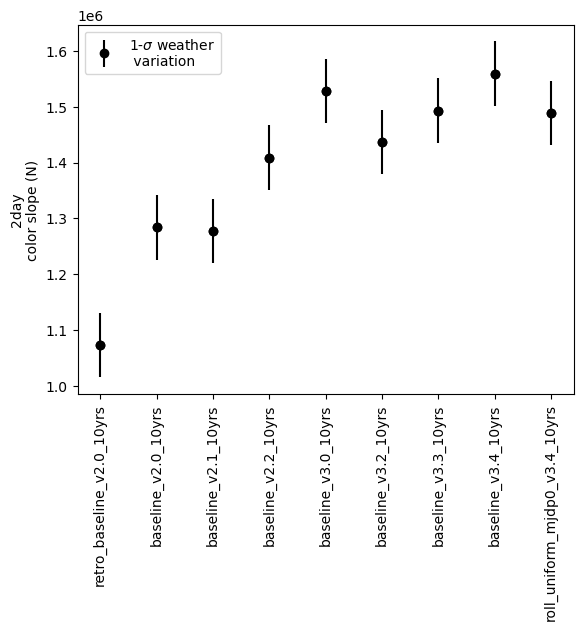

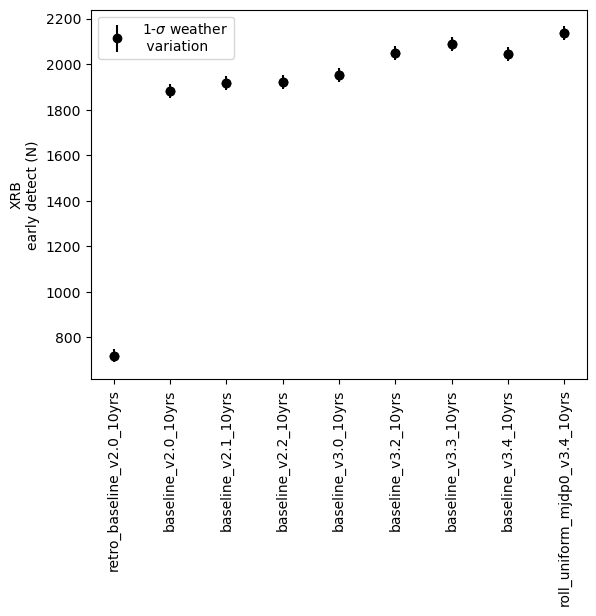

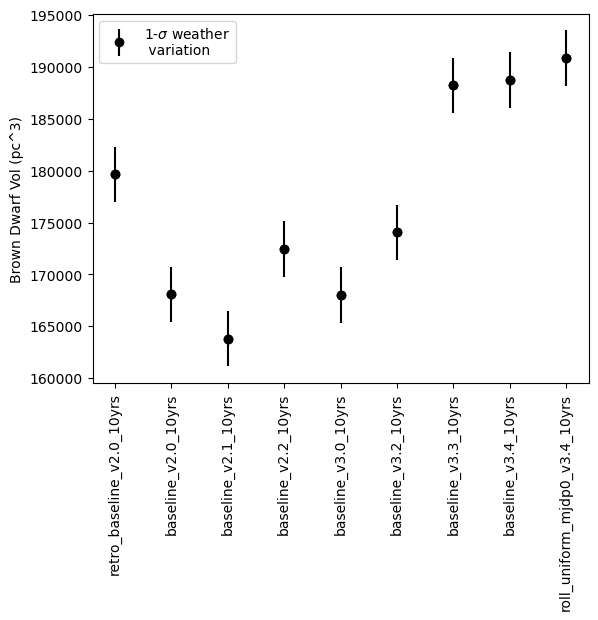

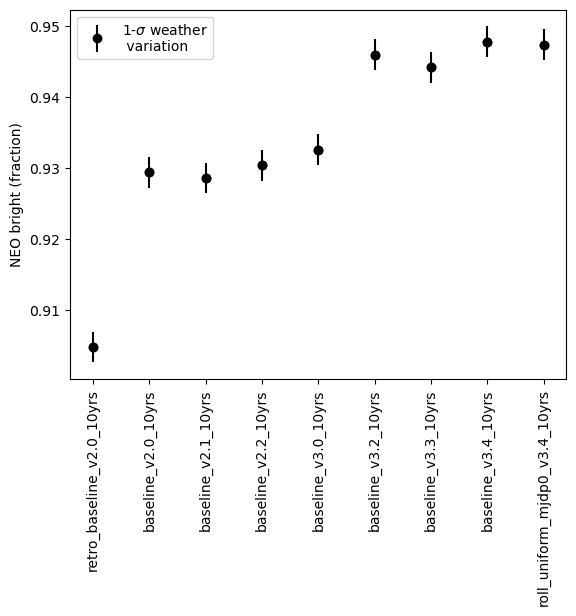

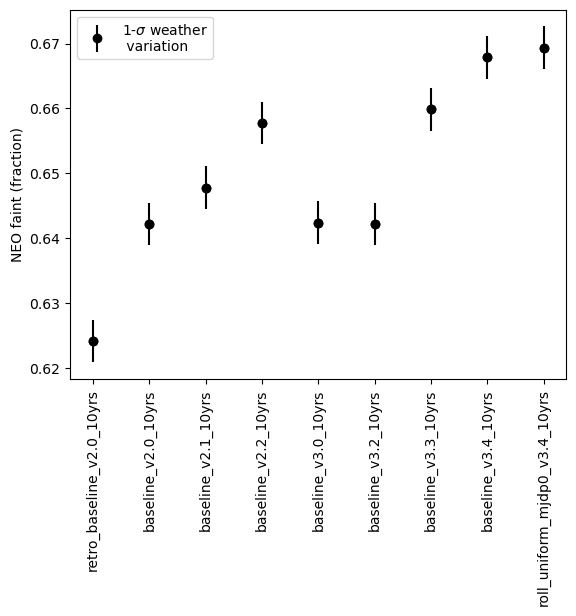

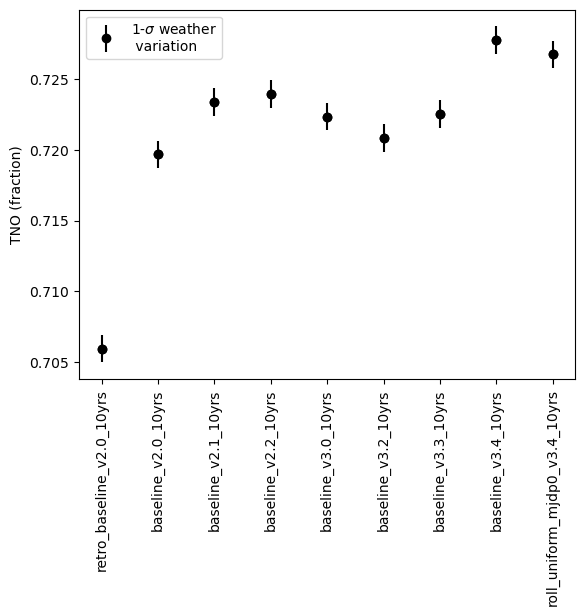

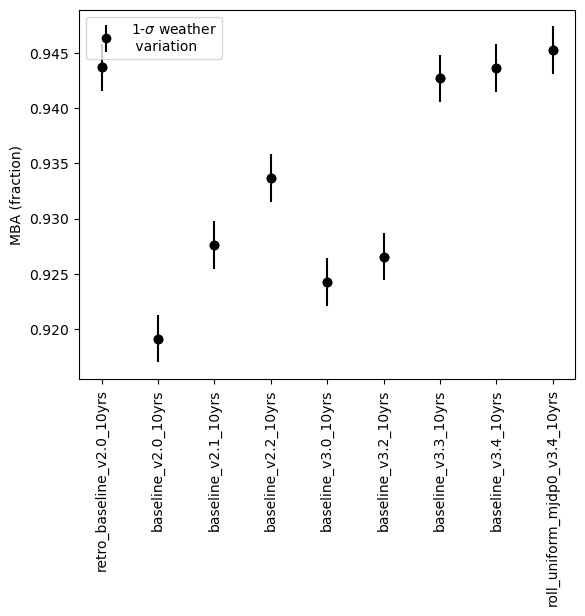

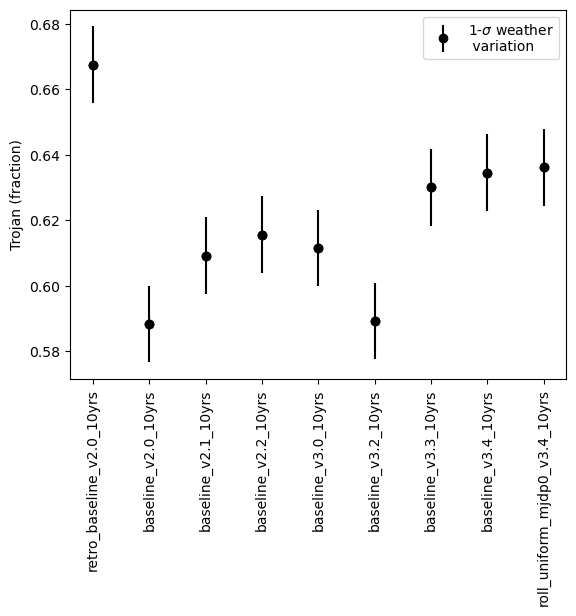

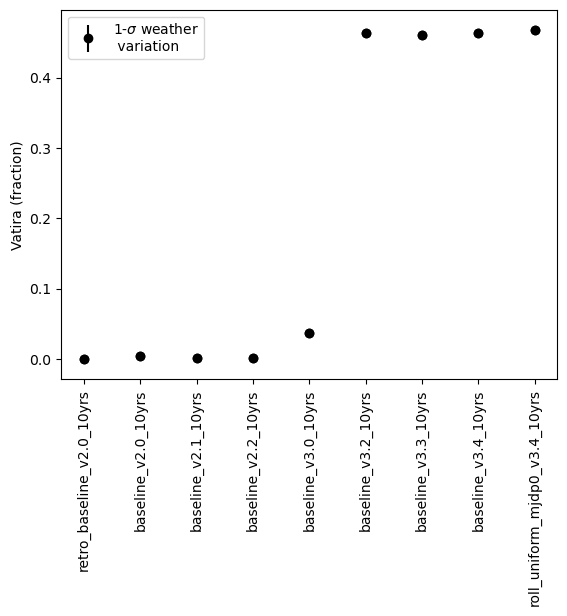

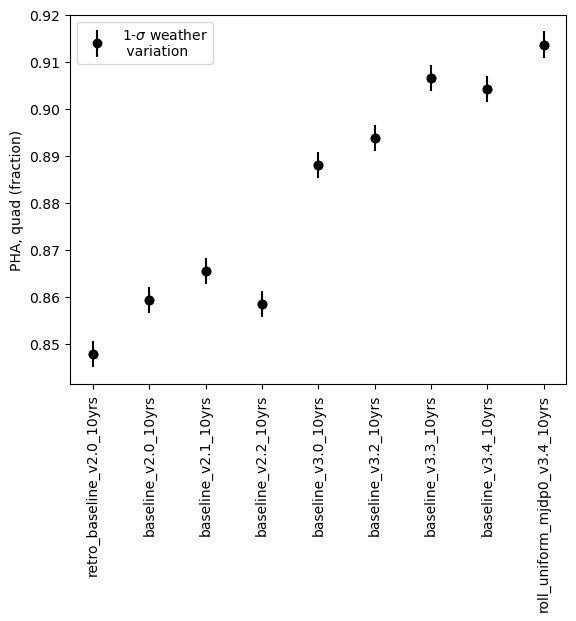

In [23]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_23041/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


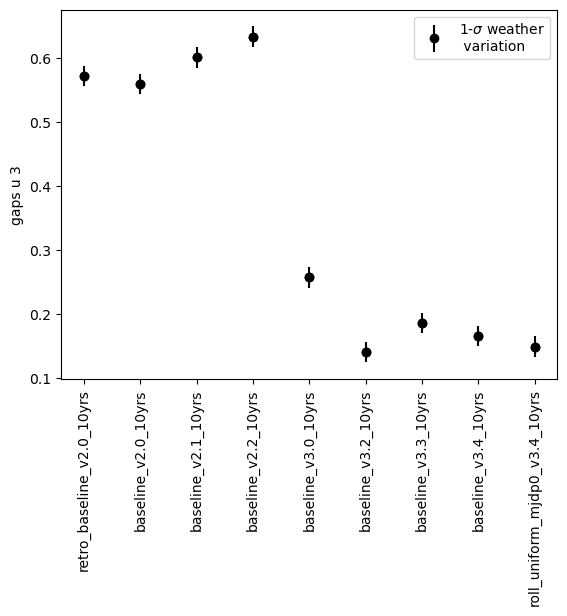

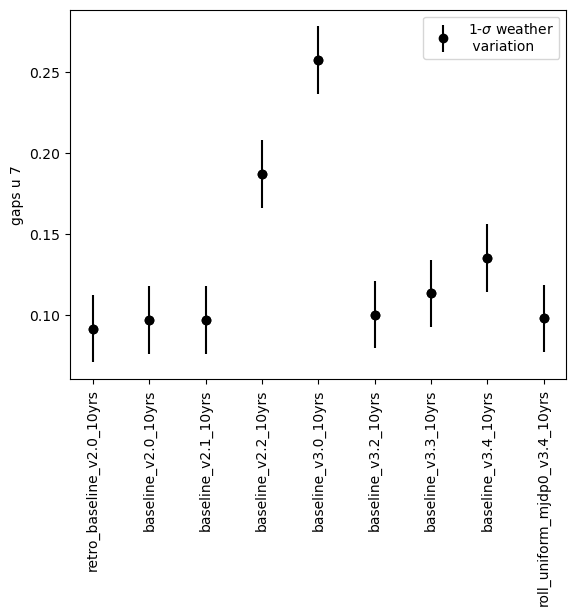

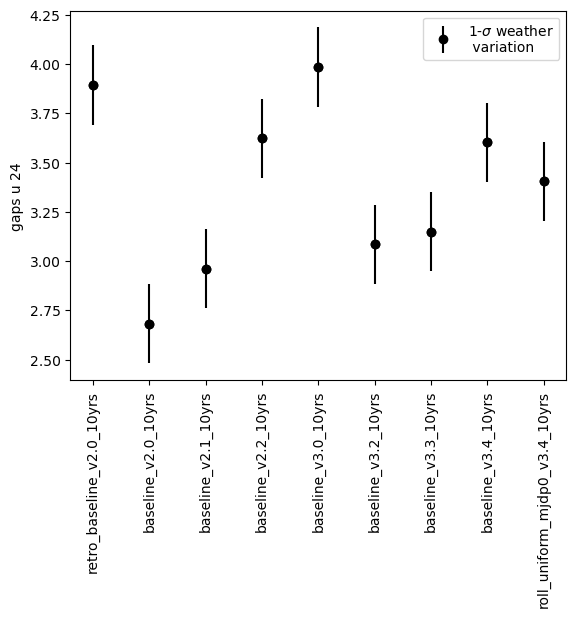

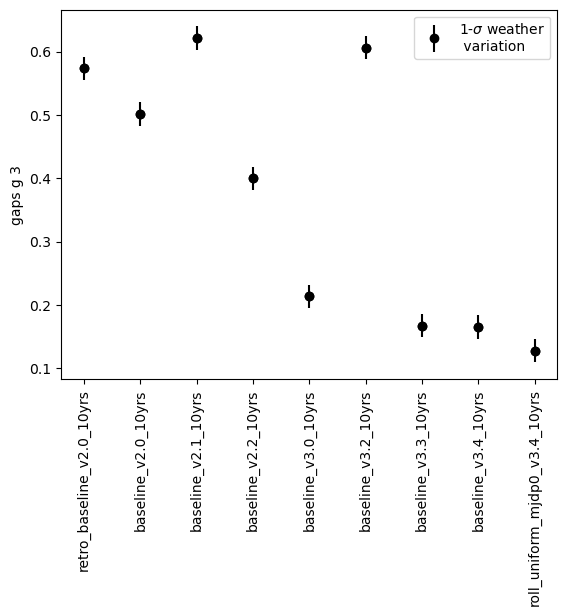

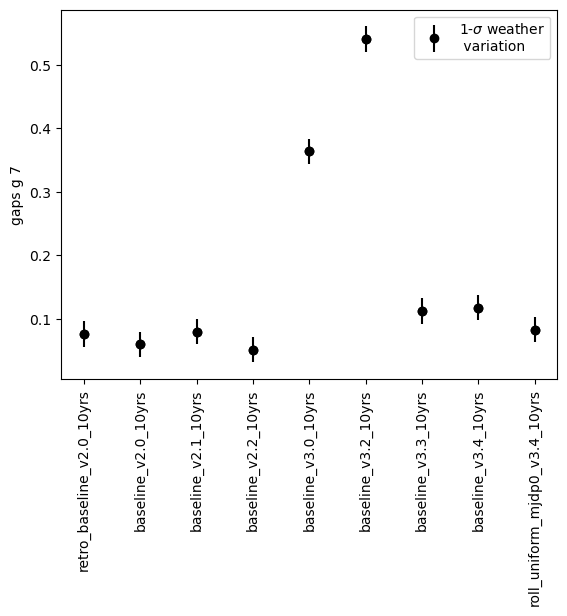

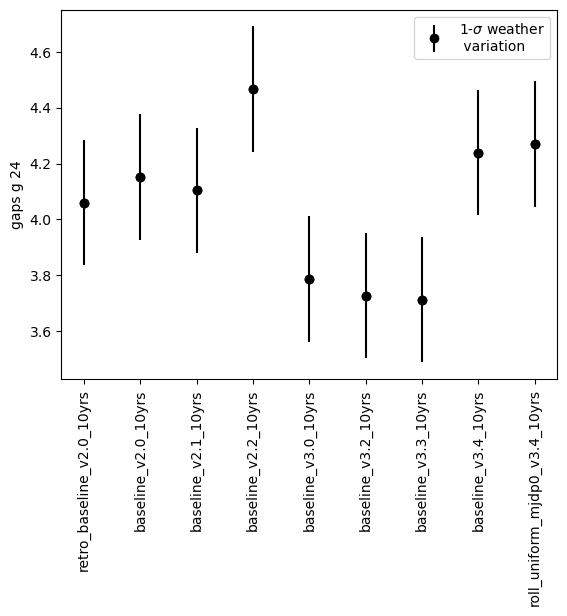

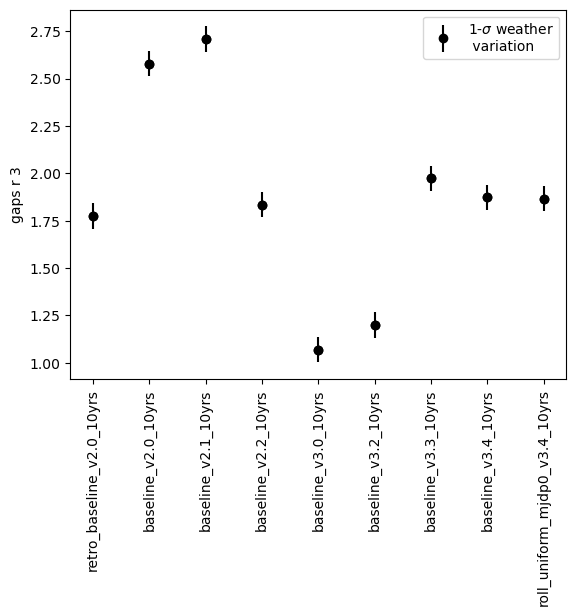

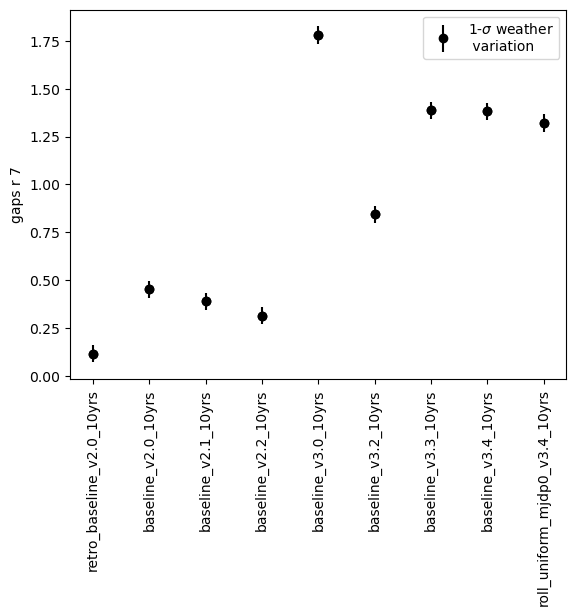

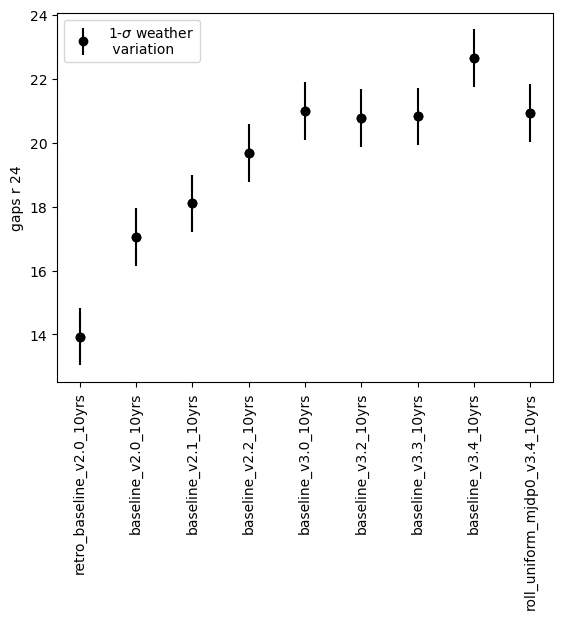

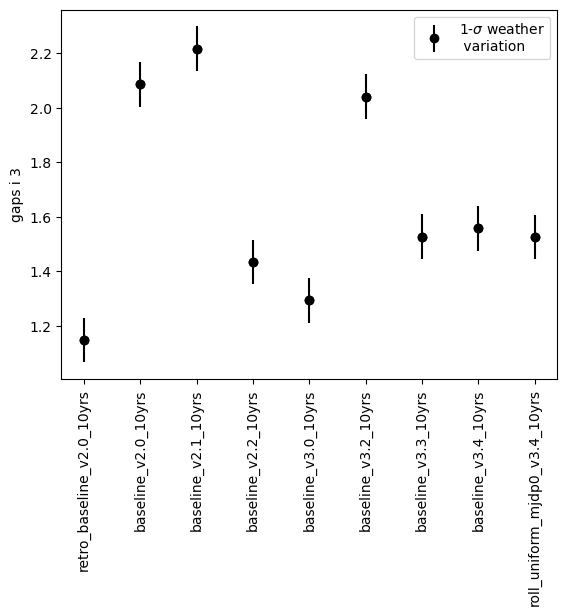

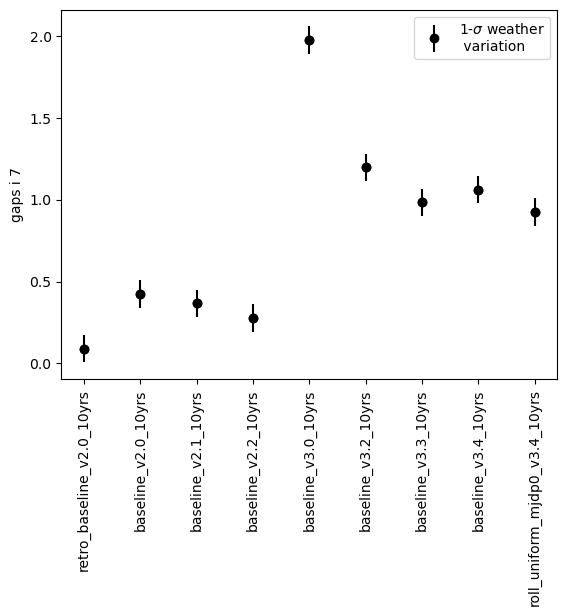

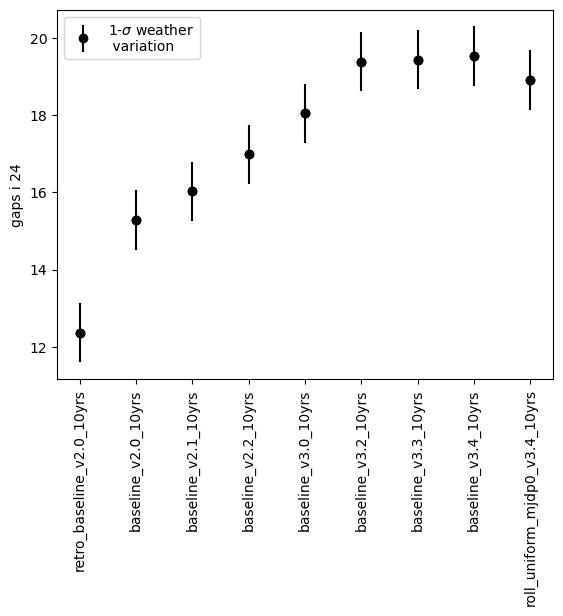

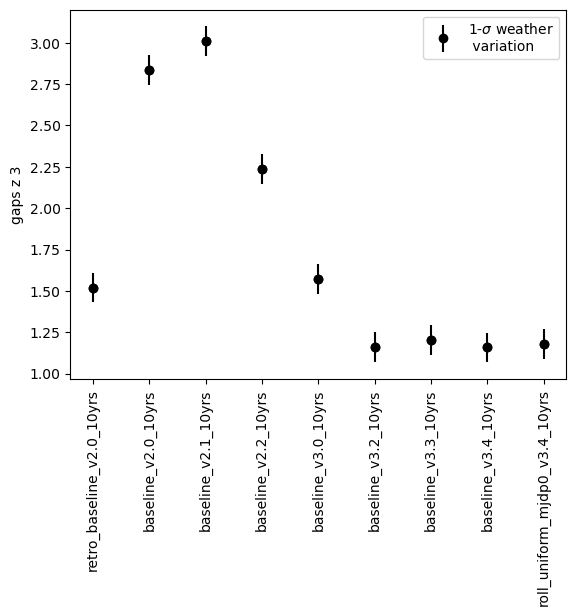

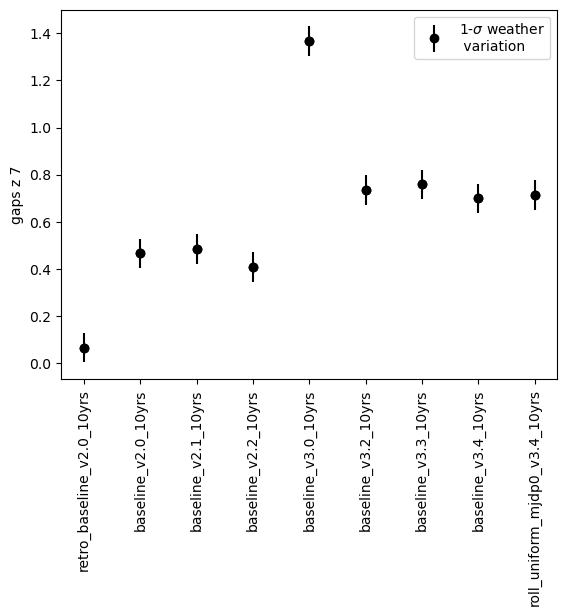

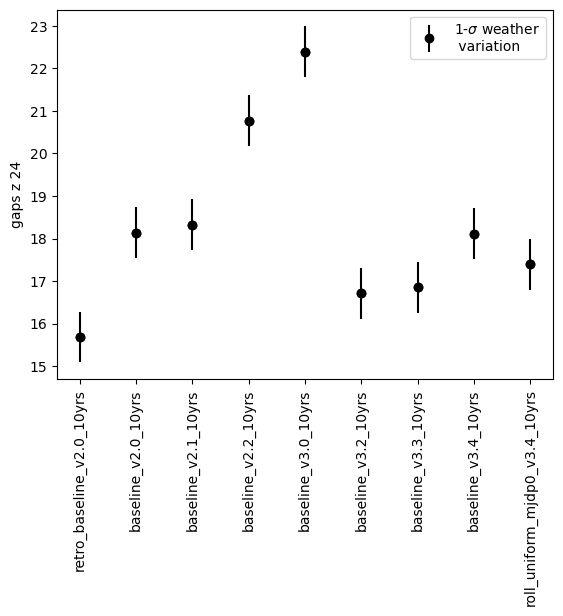

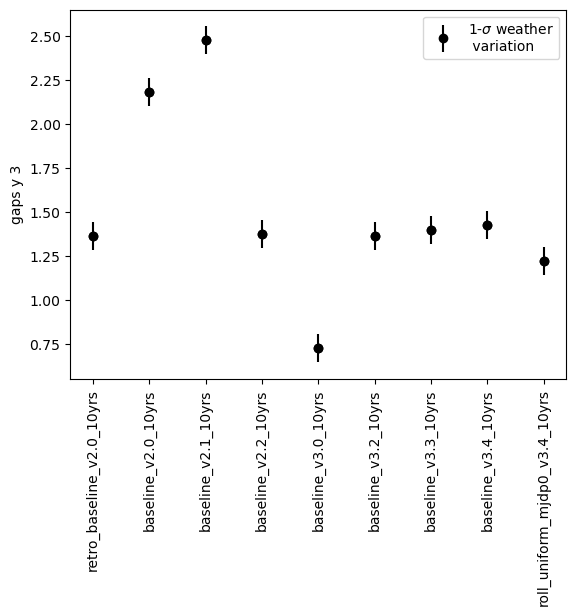

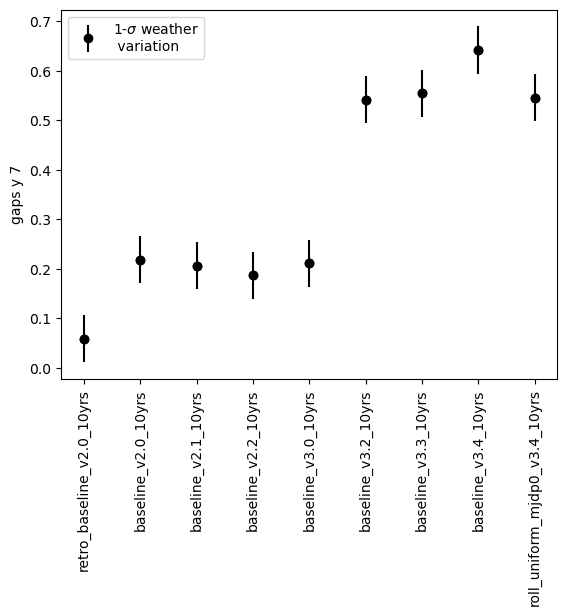

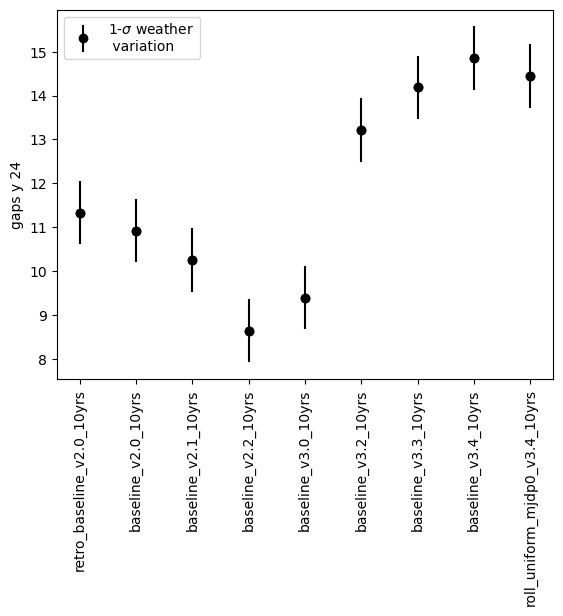

In [24]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_23041/3981456560.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',


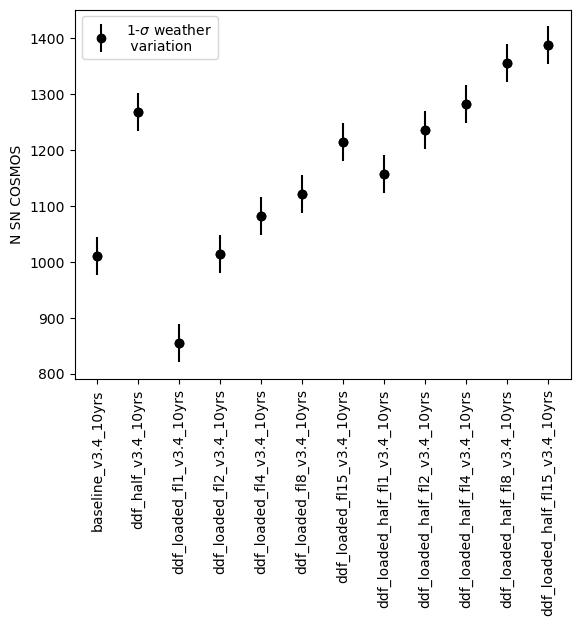

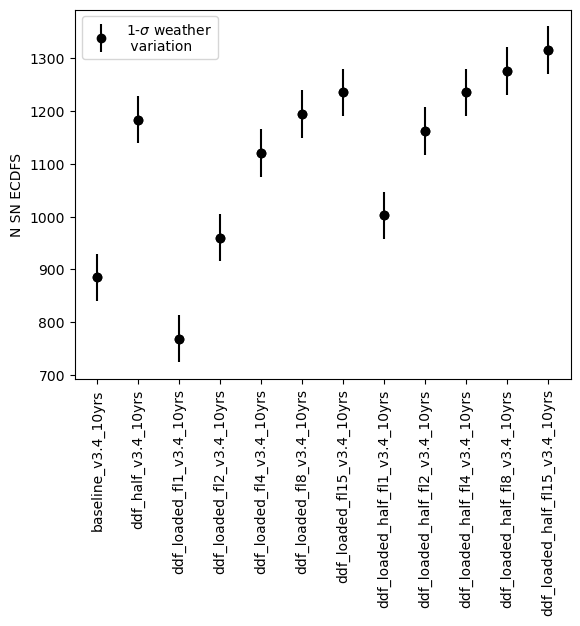

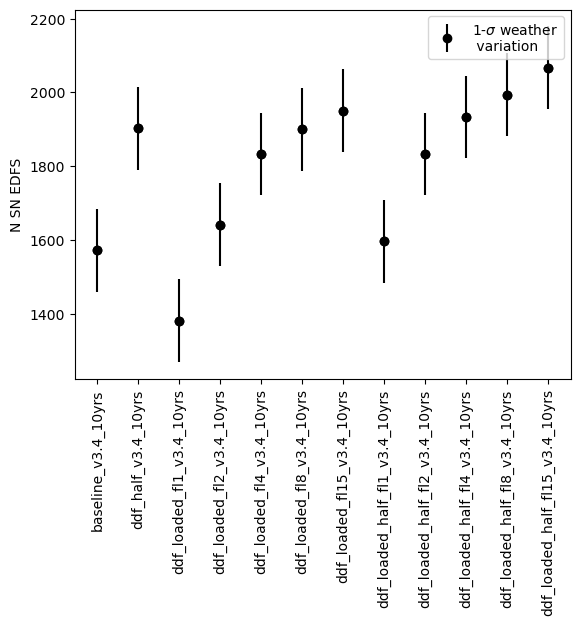

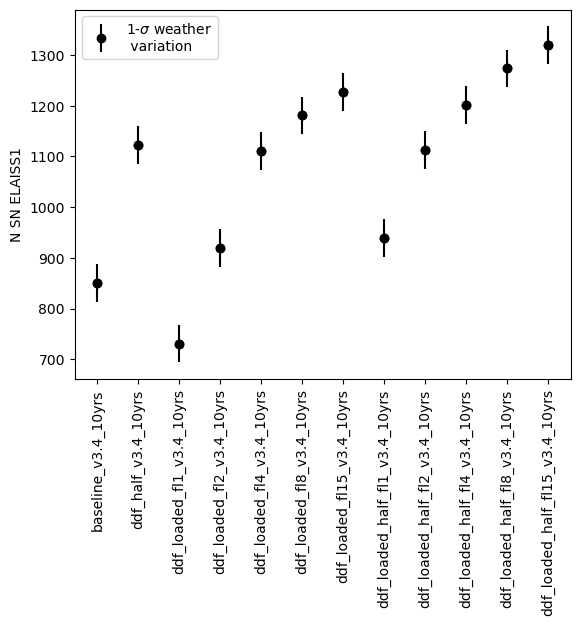

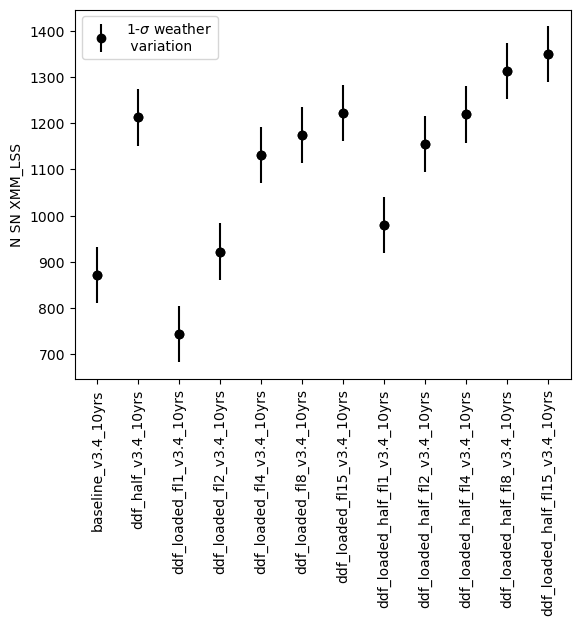

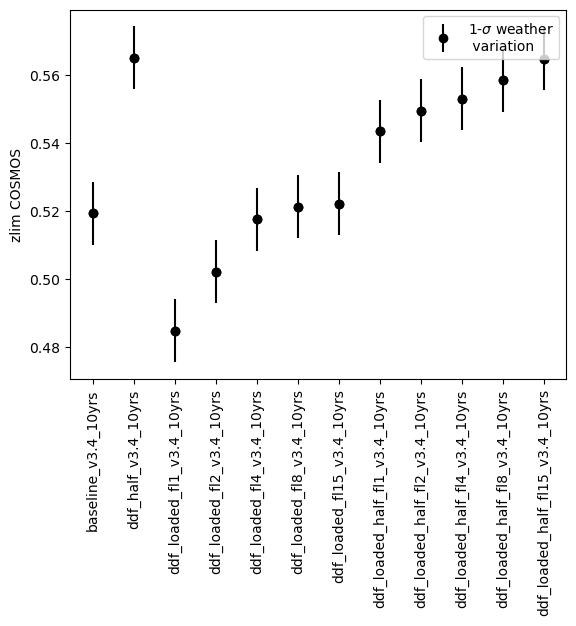

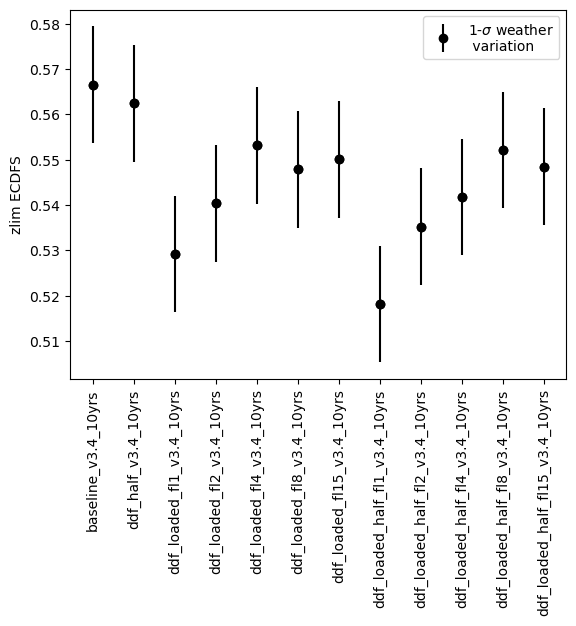

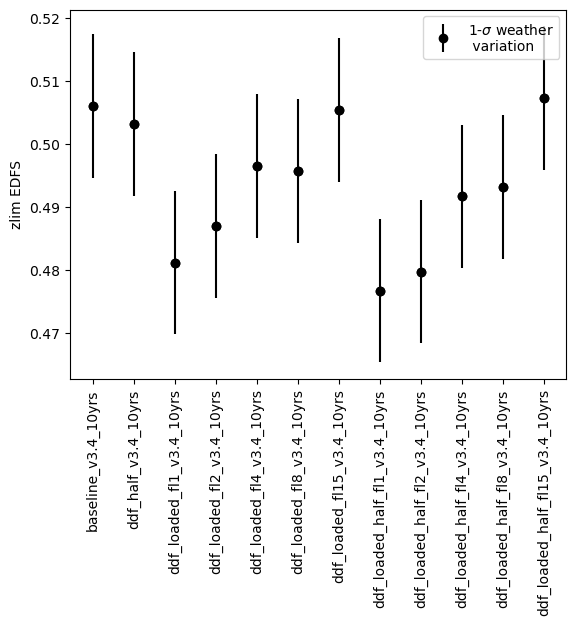

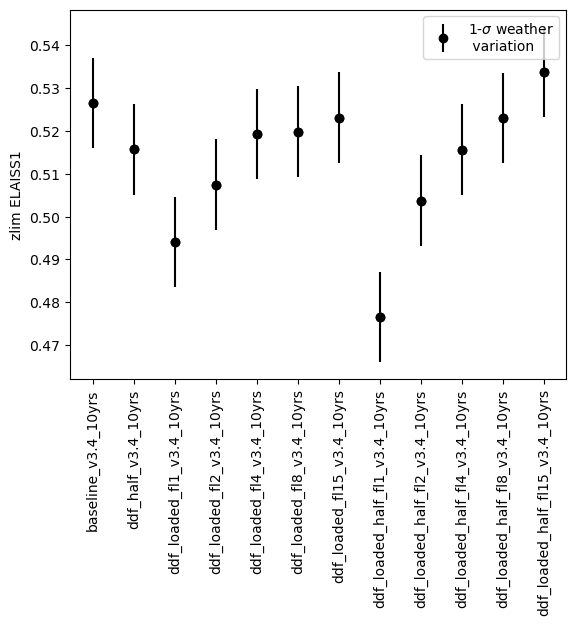

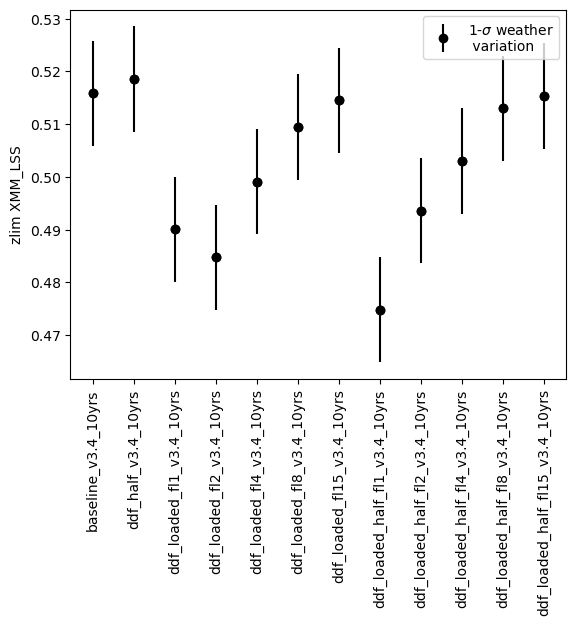

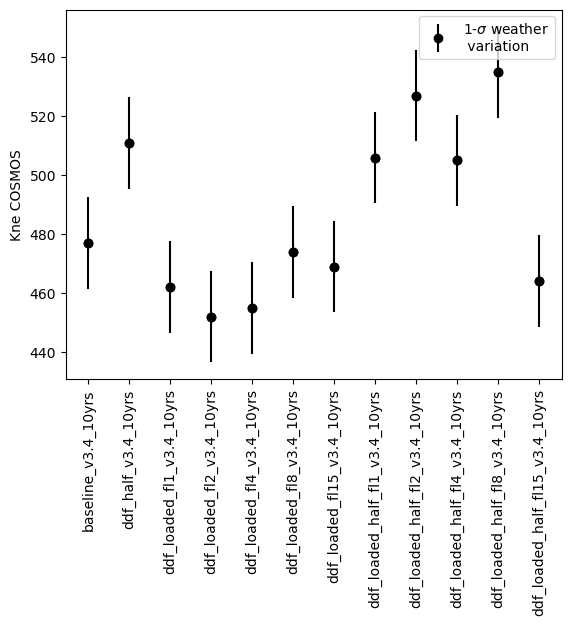

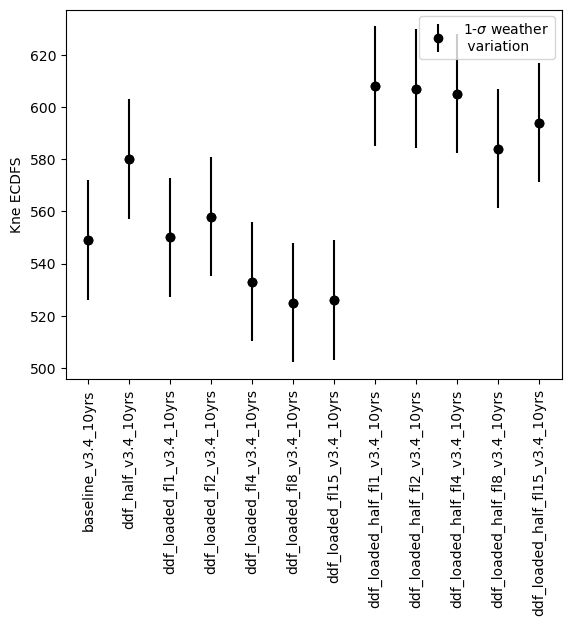

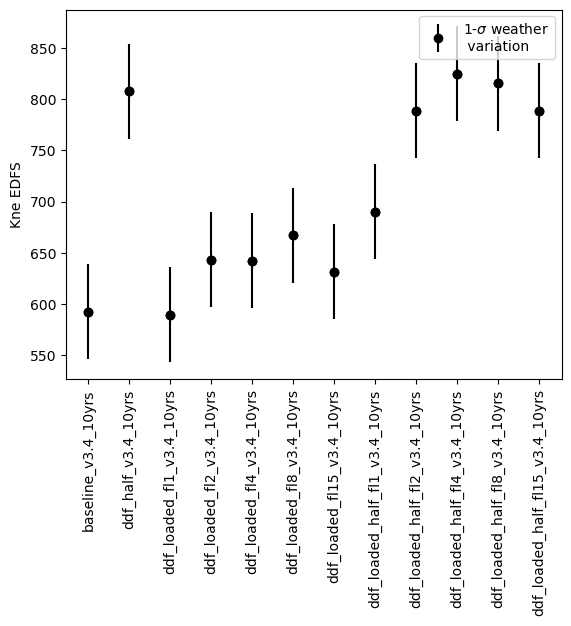

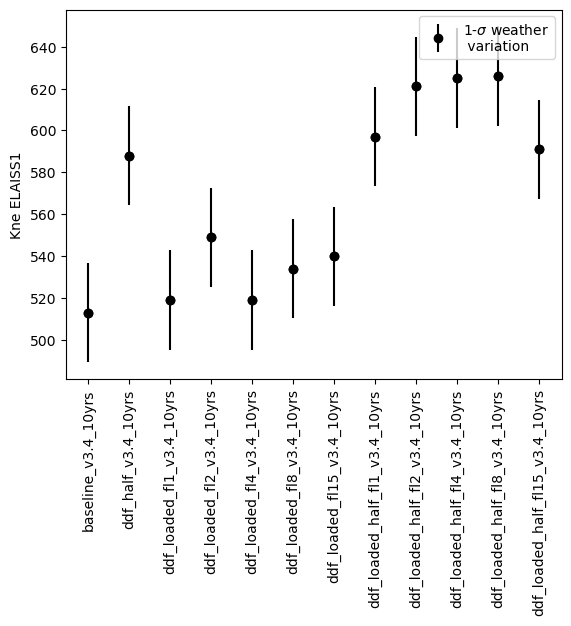

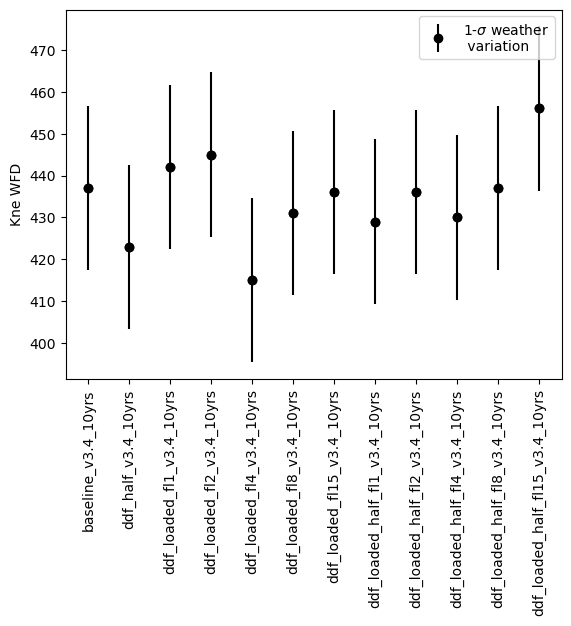

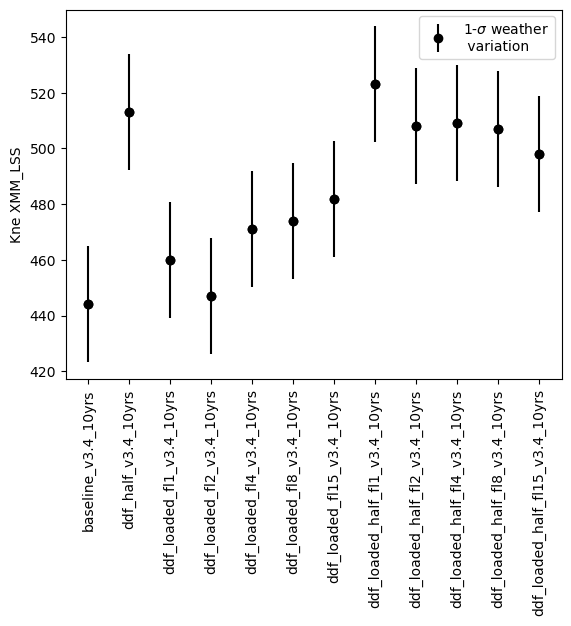

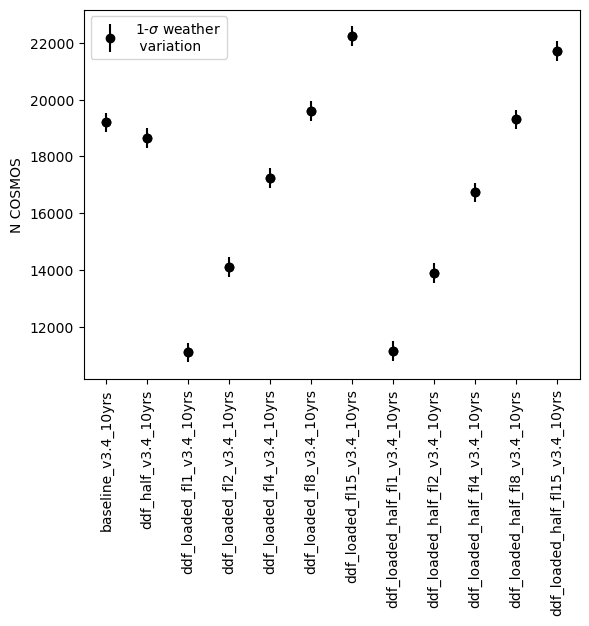

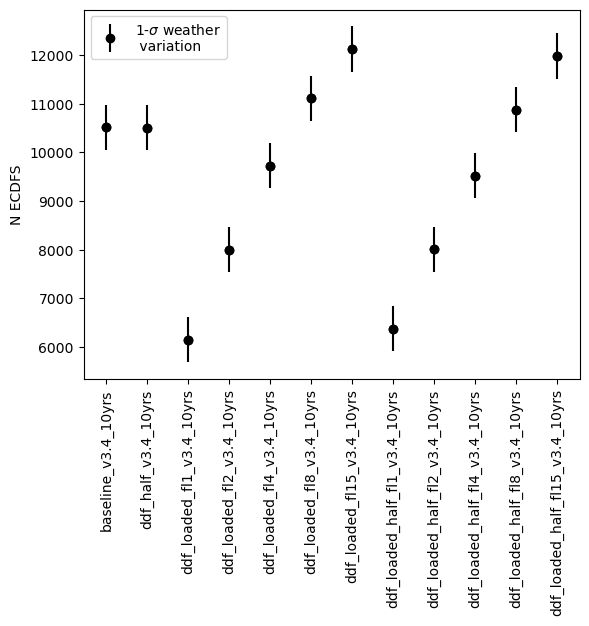

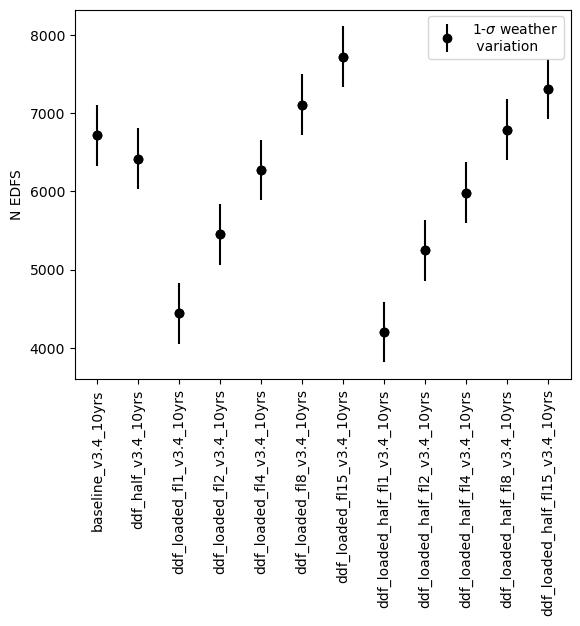

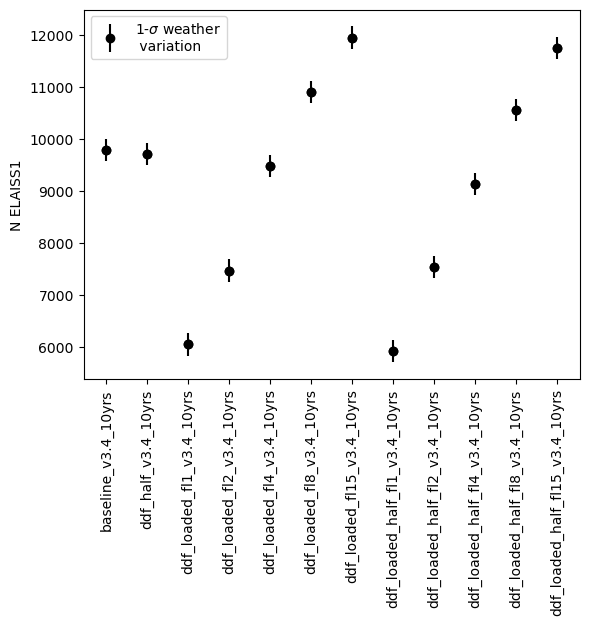

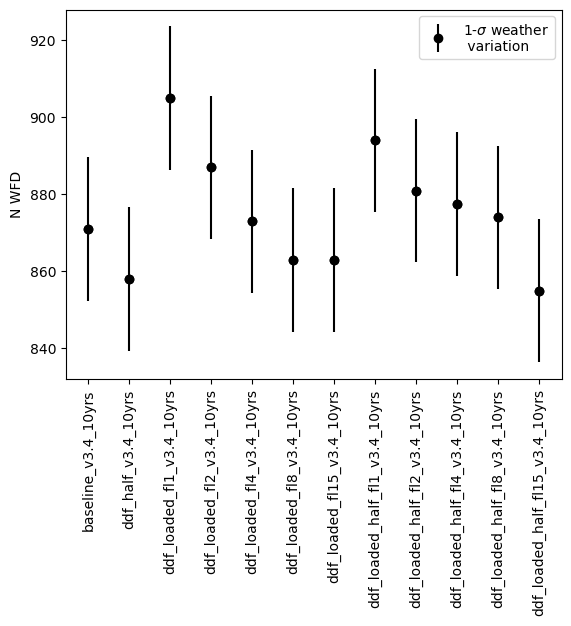

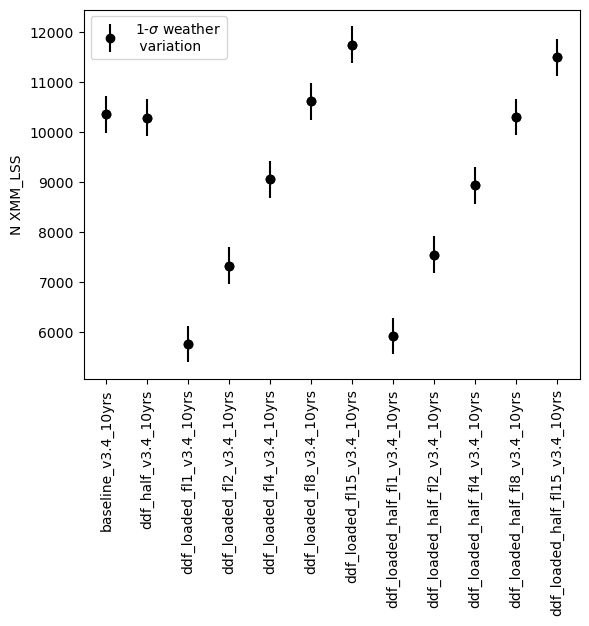

In [25]:
#times = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'ddf' in run and 'short' not in run]
times = ['baseline_v3.4_10yrs',
 'ddf_half_v3.4_10yrs',
 
 'ddf_loaded_fl1_v3.4_10yrs',
 'ddf_loaded_fl2_v3.4_10yrs',
 'ddf_loaded_fl4_v3.4_10yrs',
 'ddf_loaded_fl8_v3.4_10yrs',
 'ddf_loaded_fl15_v3.4_10yrs',
 'ddf_loaded_half_fl1_v3.4_10yrs',
 'ddf_loaded_half_fl2_v3.4_10yrs',
 'ddf_loaded_half_fl4_v3.4_10yrs',
 'ddf_loaded_half_fl8_v3.4_10yrs',
        'ddf_loaded_half_fl15_v3.4_10yrs',]
sub_gaps = ddf_data.reindex(labels=times)



for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

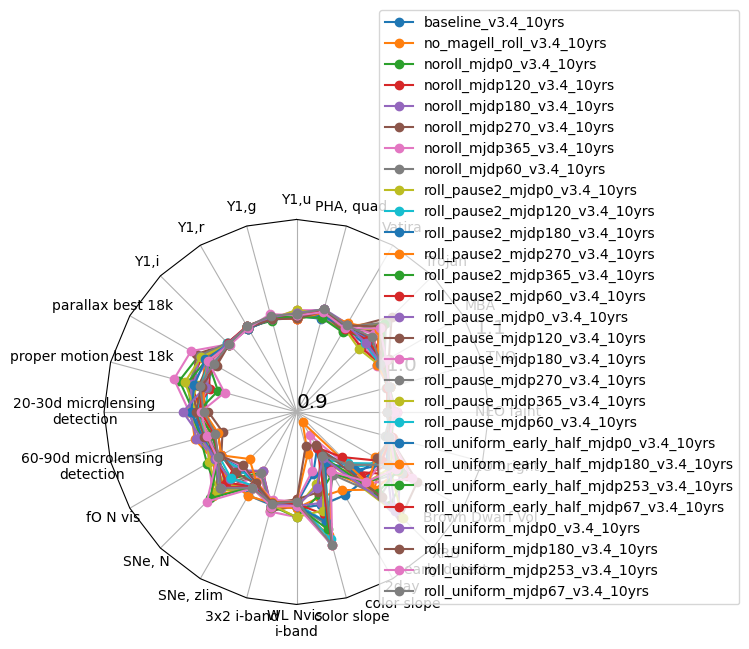

In [26]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'roll' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

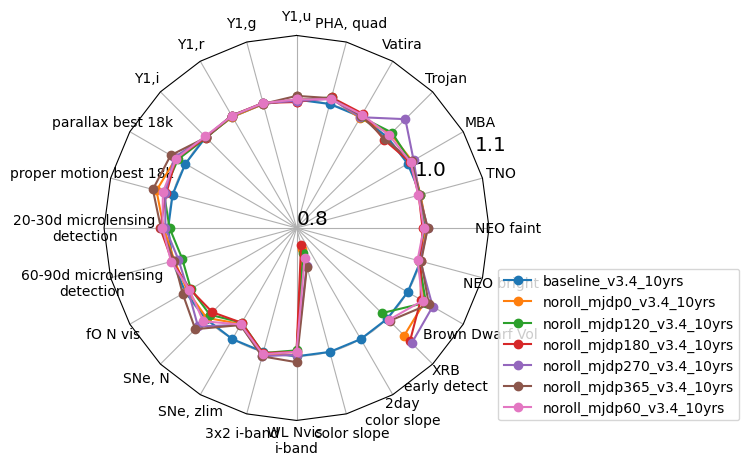

In [27]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'noroll' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

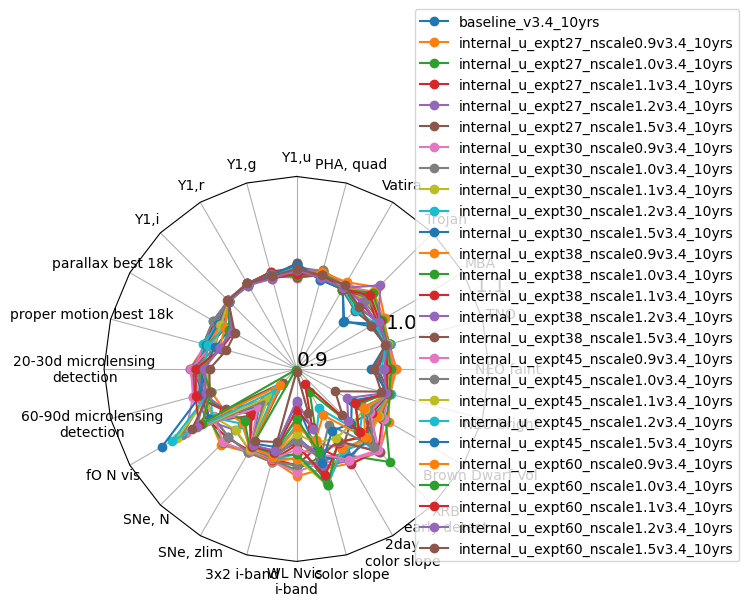

In [28]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'u_exp' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

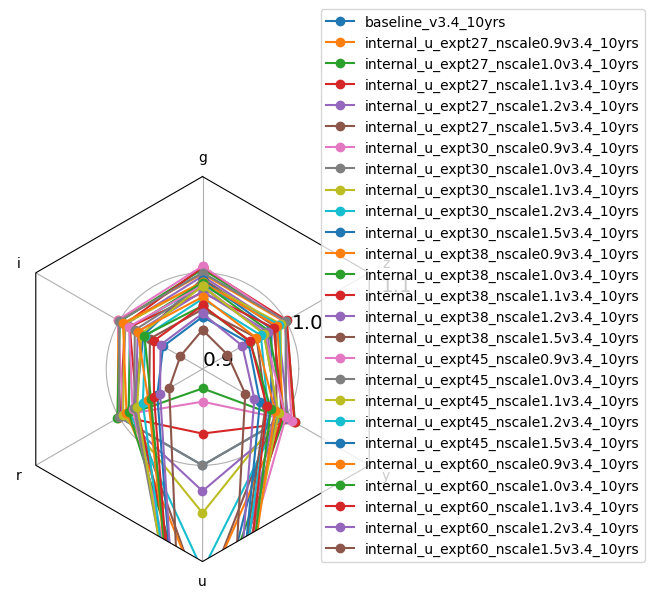

In [29]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'u_exp' in run]

ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.90, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

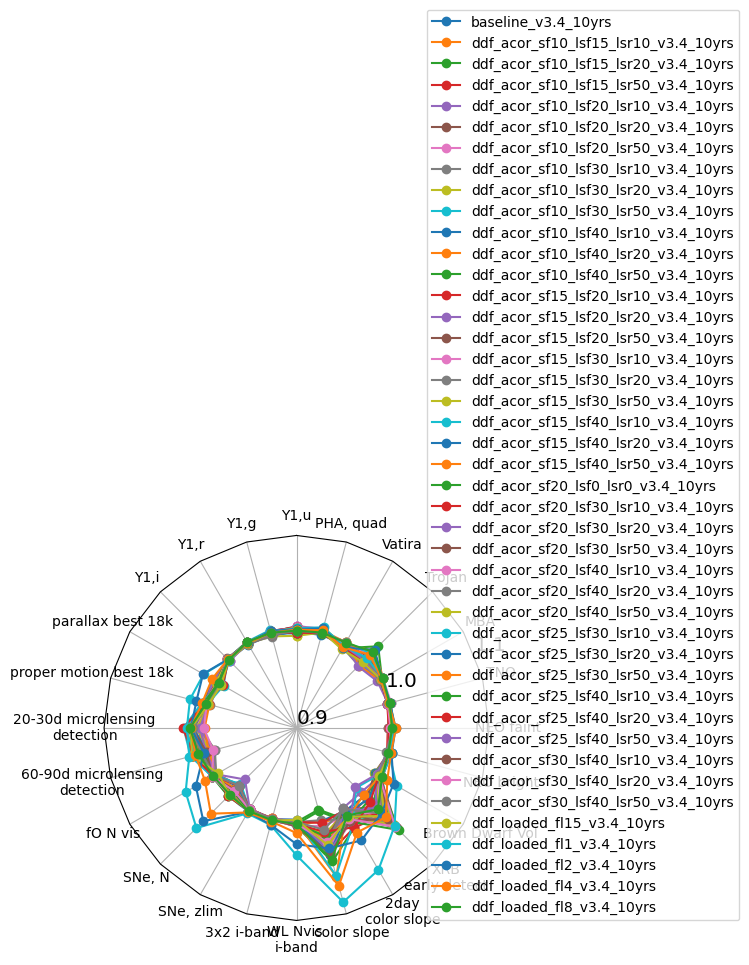

In [30]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' not in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

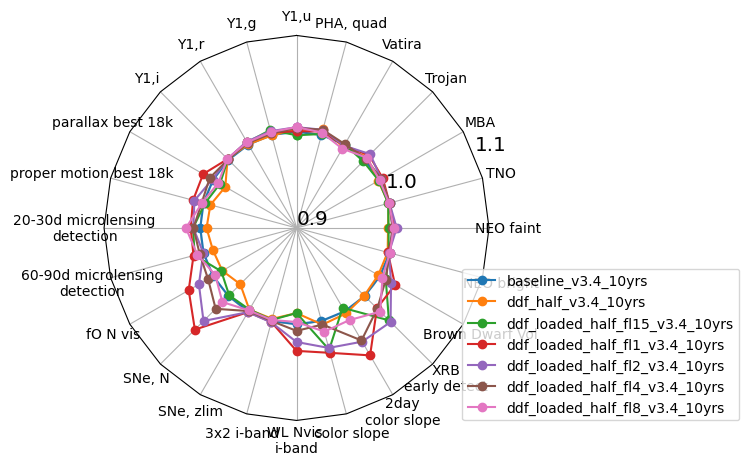

In [31]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' in run]


ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

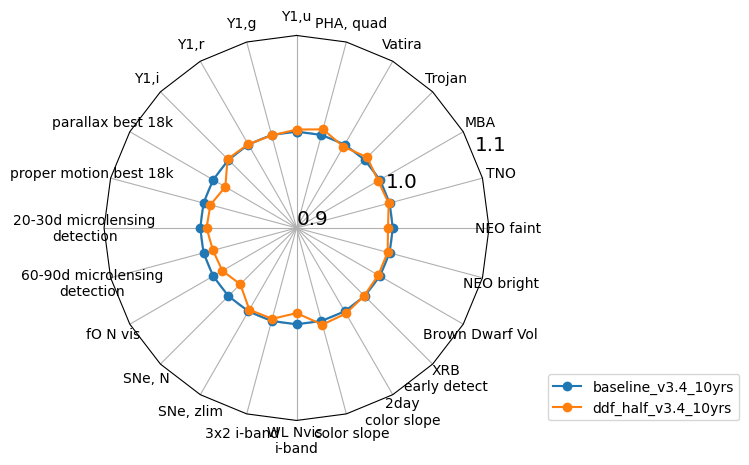

In [32]:
runs = ['baseline_v3.4_10yrs', 'ddf_half_v3.4_10yrs'] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

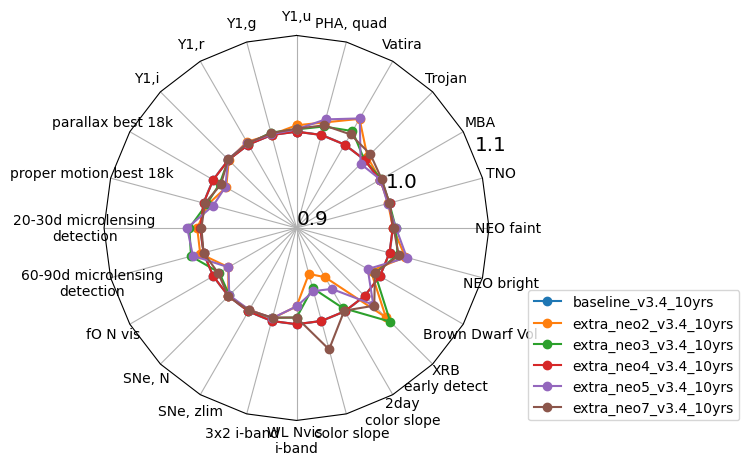

In [33]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'extra_n' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

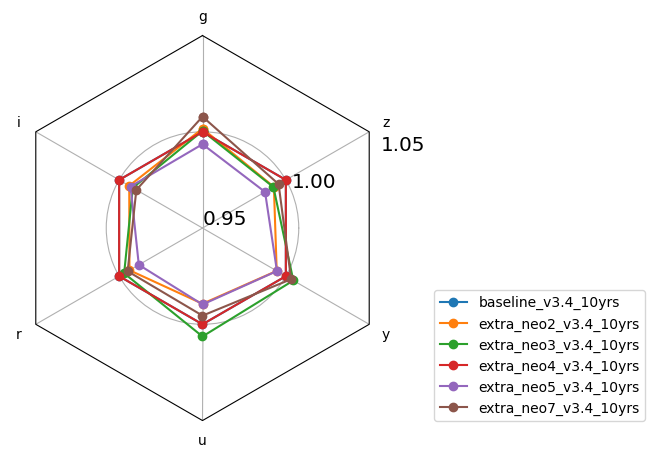

In [34]:
#runs = ['baseline_v3.4_10yrs'] + ['too_100_4v3.4_10yrs'] 

ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

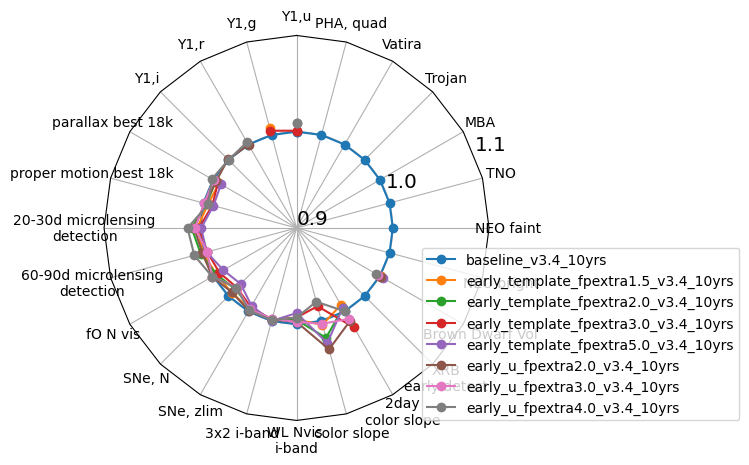

In [56]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'early_' in run and 'roll' not in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [57]:
ndata

Y1,u      Y1,g      Y1,r      Y1,i  \
baseline_v3.4_10yrs                   1.000000  1.000000  1.000000  1.000000   
early_template_fpextra1.5_v3.4_10yrs       NaN  1.007858       NaN       NaN   
early_template_fpextra2.0_v3.4_10yrs       NaN       NaN       NaN       NaN   
early_template_fpextra3.0_v3.4_10yrs  1.000995  1.004615       NaN       NaN   
early_template_fpextra5.0_v3.4_10yrs       NaN       NaN  1.002482       NaN   
early_u_fpextra2.0_v3.4_10yrs              NaN       NaN  0.999628  1.000867   
early_u_fpextra3.0_v3.4_10yrs              NaN       NaN       NaN       NaN   
early_u_fpextra4.0_v3.4_10yrs         1.008530       NaN  1.003102  0.999876   

                                      parallax best 18k  \
baseline_v3.4_10yrs                            1.000000   
early_template_fpextra1.5_v3.4_10yrs           0.992983   
early_template_fpextra2.0_v3.4_10yrs           0.996924   
early_template_fpextra3.0_v3.4_10yrs           0.994293   
early_template_fpextra5.0_v3.4_10yrs           0.990621   
early_u_fpextra2.0_v3.4_10yrs                  0.996577   
early_u_fpextra3.0_v3.4_10yrs                  0.999565   
early_u_fpextra4.0_v3.4_10yrs                  1.001620   

                                      proper motion best 18k  \
baseline_v3.4_10yrs                                 1.000000   
early_template_fpextra1.5_v3.4_10yrs                0.995195   
early_template_fpextra2.0_v3.4_10yrs                0.996872   
early_template_fpextra3.0_v3.4_10yrs                0.990535   
early_template_fpextra5.0_v3.4_10yrs                0.989390   
early_u_fpextra2.0_v3.4_10yrs                       0.998248   
early_u_fpextra3.0_v3.4_10yrs                       0.999144   
early_u_fpextra4.0_v3.4_10yrs                       0.994919   

                                      20-30d microlensing\ndetection  \
baseline_v3.4_10yrs                                           1.0000   
early_template_fpextra1.5_v3.4_10yrs                          1.0033   
early_template_fpextra2.0_v3.4_10yrs                          1.0090   
early_template_fpextra3.0_v3.4_10yrs                          1.0013   
early_template_fpextra5.0_v3.4_10yrs                          0.9990   
early_u_fpextra2.0_v3.4_10yrs                                 1.0064   
early_u_fpextra3.0_v3.4_10yrs                                 1.0056   
early_u_fpextra4.0_v3.4_10yrs                                 1.0132   

                                      60-90d microlensing\ndetection  \
baseline_v3.4_10yrs                                           1.0000   
early_template_fpextra1.5_v3.4_10yrs                          1.0005   
early_template_fpextra2.0_v3.4_10yrs                          1.0031   
early_template_fpextra3.0_v3.4_10yrs                          0.9960   
early_template_fpextra5.0_v3.4_10yrs                          0.9967   
early_u_fpextra2.0_v3.4_10yrs                                 1.0012   
early_u_fpextra3.0_v3.4_10yrs                                 0.9961   
early_u_fpextra4.0_v3.4_10yrs                                 1.0100   

                                      fO N vis    SNe, N  ...  \
baseline_v3.4_10yrs                   1.000000  1.000000  ...   
early_template_fpextra1.5_v3.4_10yrs  0.996328  0.995225  ...   
early_template_fpextra2.0_v3.4_10yrs  0.996328  0.989882  ...   
early_template_fpextra3.0_v3.4_10yrs  0.992656  0.987573  ...   
early_template_fpextra5.0_v3.4_10yrs  0.987760  0.982183  ...   
early_u_fpextra2.0_v3.4_10yrs         1.001224  0.994750  ...   
early_u_fpextra3.0_v3.4_10yrs         1.001224  0.987547  ...   
early_u_fpextra4.0_v3.4_10yrs         1.001224  0.988212  ...   

                                      2day\ncolor slope  XRB\nearly detect  \
baseline_v3.4_10yrs                            1.000000           1.000000   
early_template_fpextra1.5_v3.4_10yrs           0.992245           0.281449   
early_template_fpextra2.0_v3.4_10yrs           0.996277           0.296623   
early_template_f

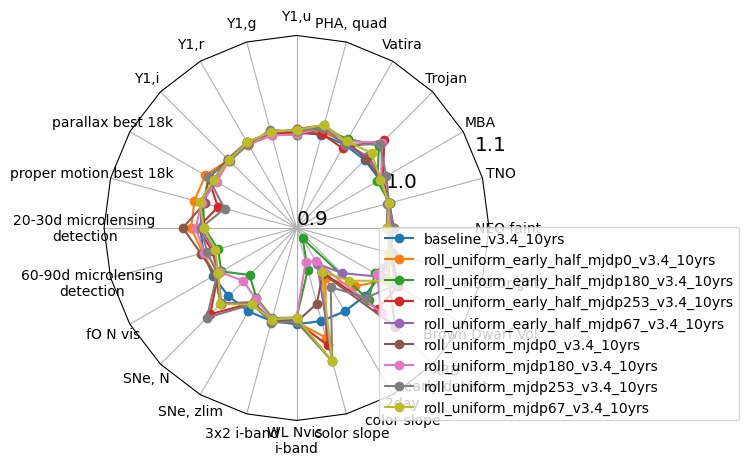

In [36]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'uniform' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

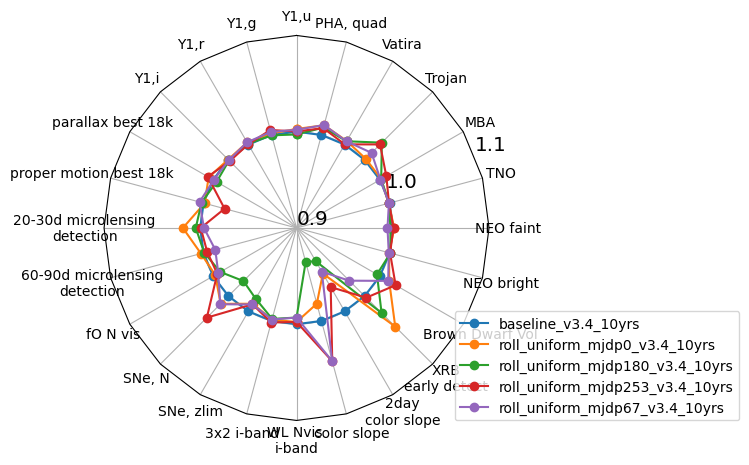

In [37]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'uniform' in run and 'half' not in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

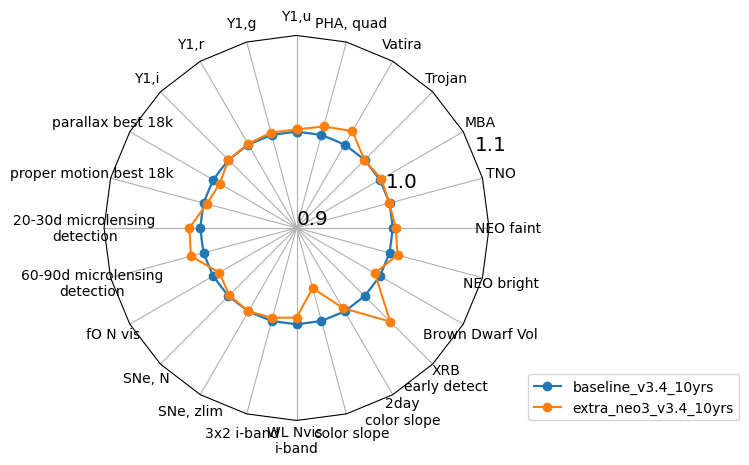

In [38]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'extra_neo3' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

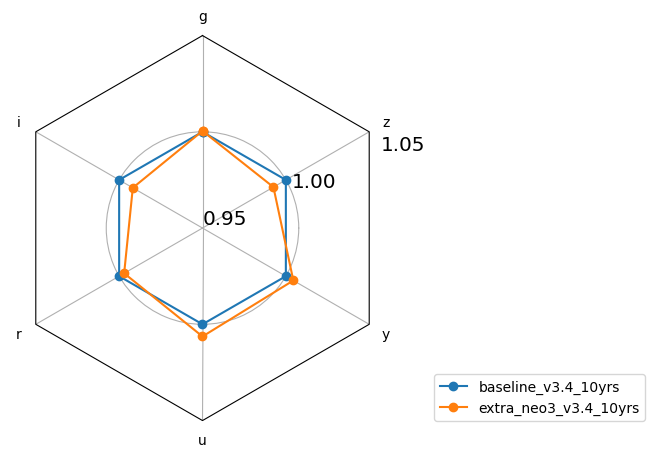

In [39]:
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

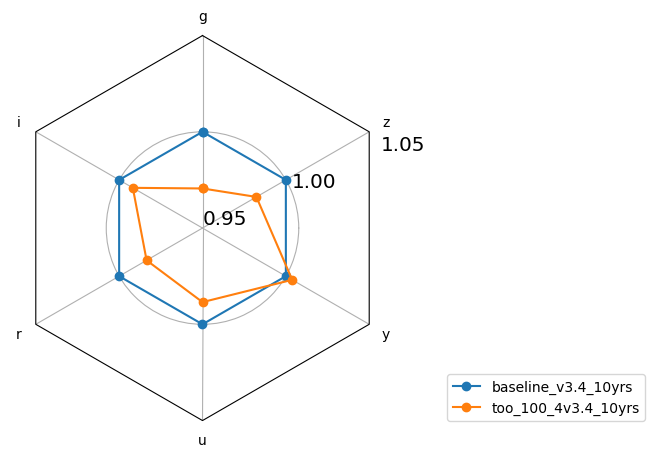

In [40]:
runs = ['baseline_v3.4_10yrs'] + ['too_100_4v3.4_10yrs'] 

ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [41]:
mag_data.loc[runs]

g          i          r          u          y  \
baseline_v3.4_10yrs  26.787451  26.453652  26.938063  25.333755  24.804475   
too_100_4v3.4_10yrs  26.758018  26.445450  26.921592  25.322232  24.808274   

                             z  
baseline_v3.4_10yrs  25.752748  
too_100_4v3.4_10yrs  25.735079

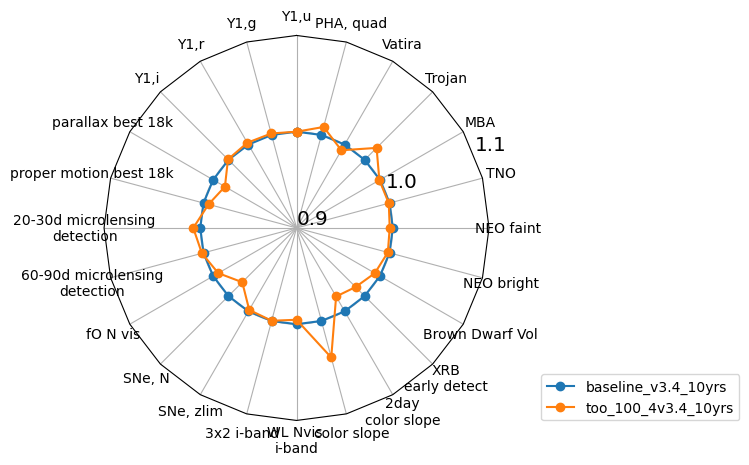

In [42]:
runs = ['baseline_v3.4_10yrs'] + ['too_100_4v3.4_10yrs'] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

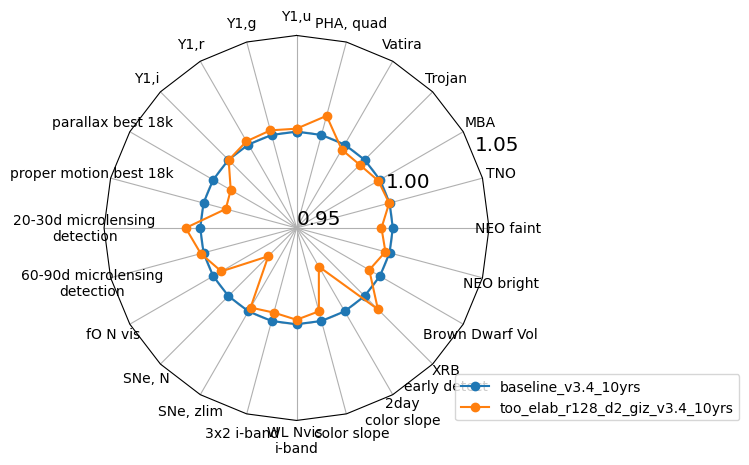

In [43]:
runs = ['baseline_v3.4_10yrs'] + ['too_elab_r128_d2_giz_v3.4_10yrs'] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [44]:
ndata

Y1,u      Y1,g      Y1,r      Y1,i  \
baseline_v3.4_10yrs              1.000000  1.000000  1.000000  1.000000   
too_elab_r128_d2_giz_v3.4_10yrs  1.001564  1.002495  1.001985  0.999876   

                                 parallax best 18k  proper motion best 18k  \
baseline_v3.4_10yrs                       1.000000                1.000000   
too_elab_r128_d2_giz_v3.4_10yrs           0.989473                0.988052   

                                 20-30d microlensing\ndetection  \
baseline_v3.4_10yrs                                      1.0000   
too_elab_r128_d2_giz_v3.4_10yrs                          1.0076   

                                 60-90d microlensing\ndetection  fO N vis  \
baseline_v3.4_10yrs                                      1.0000  1.000000   
too_elab_r128_d2_giz_v3.4_10yrs                          1.0015  0.995104   

                                   SNe, N  ...  2day\ncolor slope  \
baseline_v3.4_10yrs              1.000000  ...           1.000000   
too_elab_r128_d2_giz_v3.4_10yrs  0.970771  ...           0.973187   

                                 XRB\nearly detect  Brown Dwarf Vol  \
baseline_v3.4_10yrs                        1.00000         1.000000   
too_elab_r128_d2_giz_v3.4_10yrs            1.00979         0.993621   

                                 NEO bright  NEO faint       TNO       MBA  \
baseline_v3.4_10yrs                  1.0000   1.000000  1.000000  1.000000   
too_elab_r128_d2_giz_v3.4_10yrs      0.9978   0.994125  0.999805  0.999037   

                                   Trojan  Vatira  PHA, quad  
baseline_v3.4_10yrs              1.000000   1.000   1.000000  
too_elab_r128_d2_giz_v3.4_10yrs  0.996413   0.997   1.010312  

[2 rows x 24 columns]

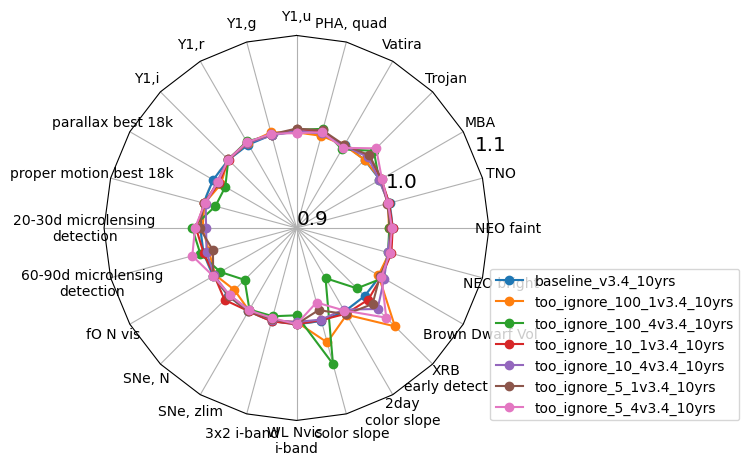

In [45]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'too' in run and 'ignore' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

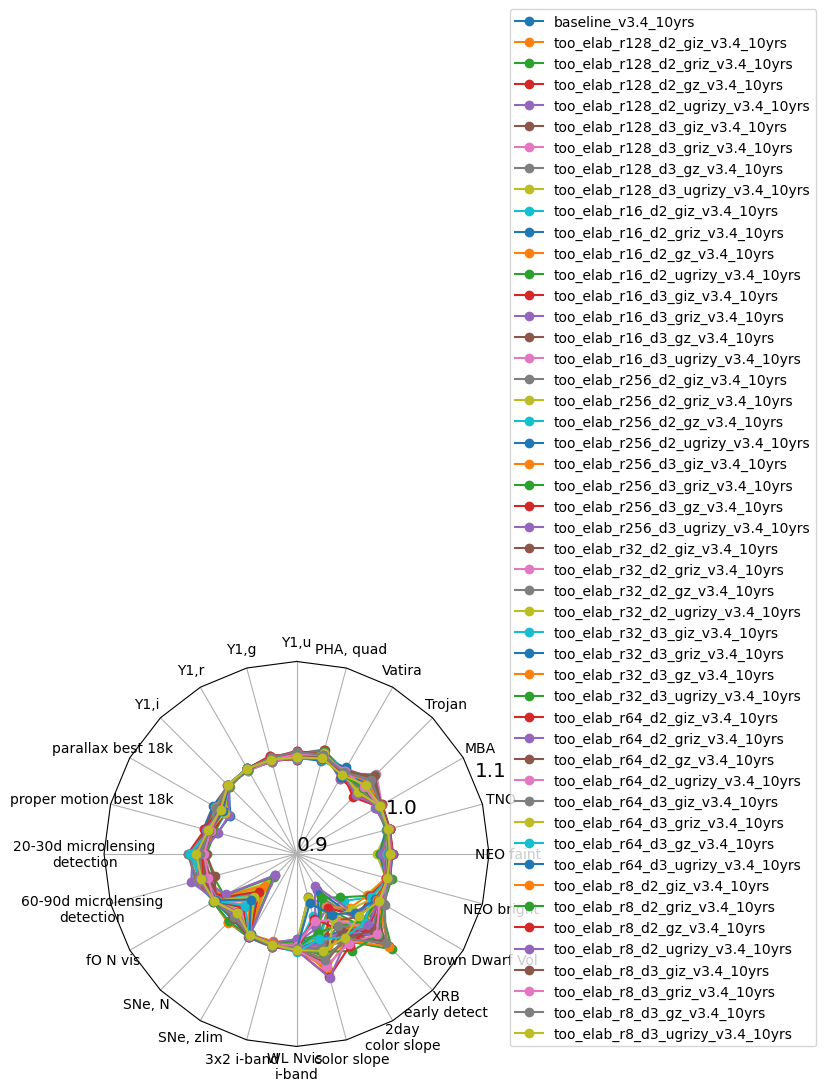

In [46]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'too_elab_r' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.85, 0))

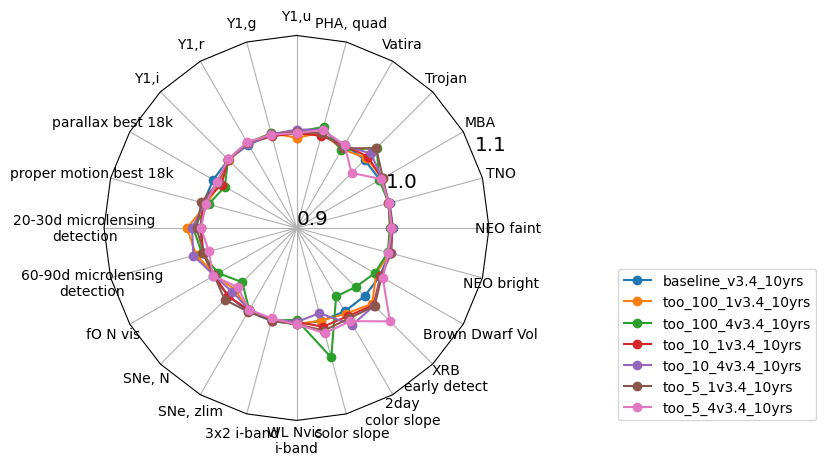

In [47]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'too_1' in run or 'too_5' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.85, 0))

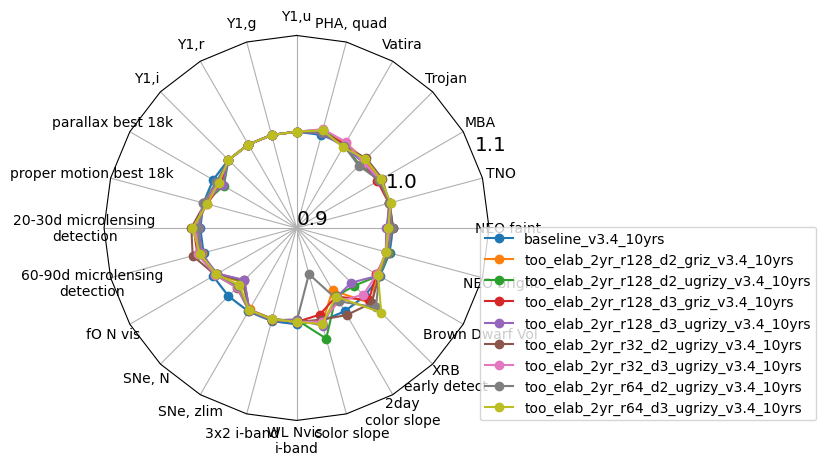

In [48]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if '2yr_' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.85, 0))

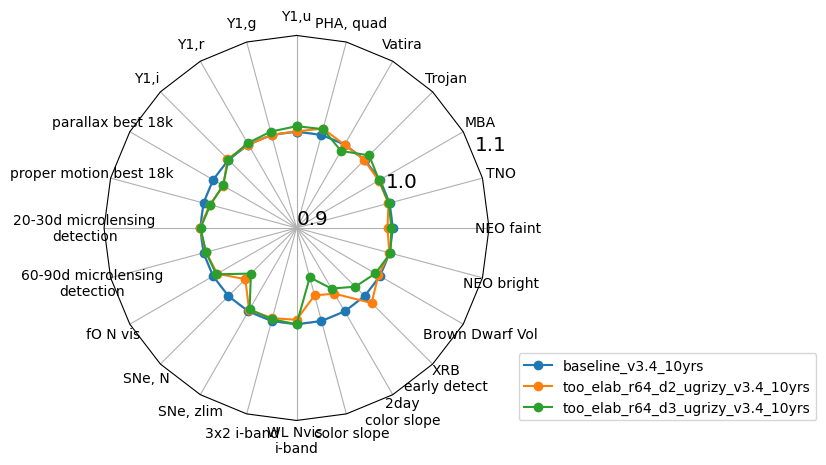

In [49]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'too_elab_r64' in run and 'ugrizy' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.85, 0))


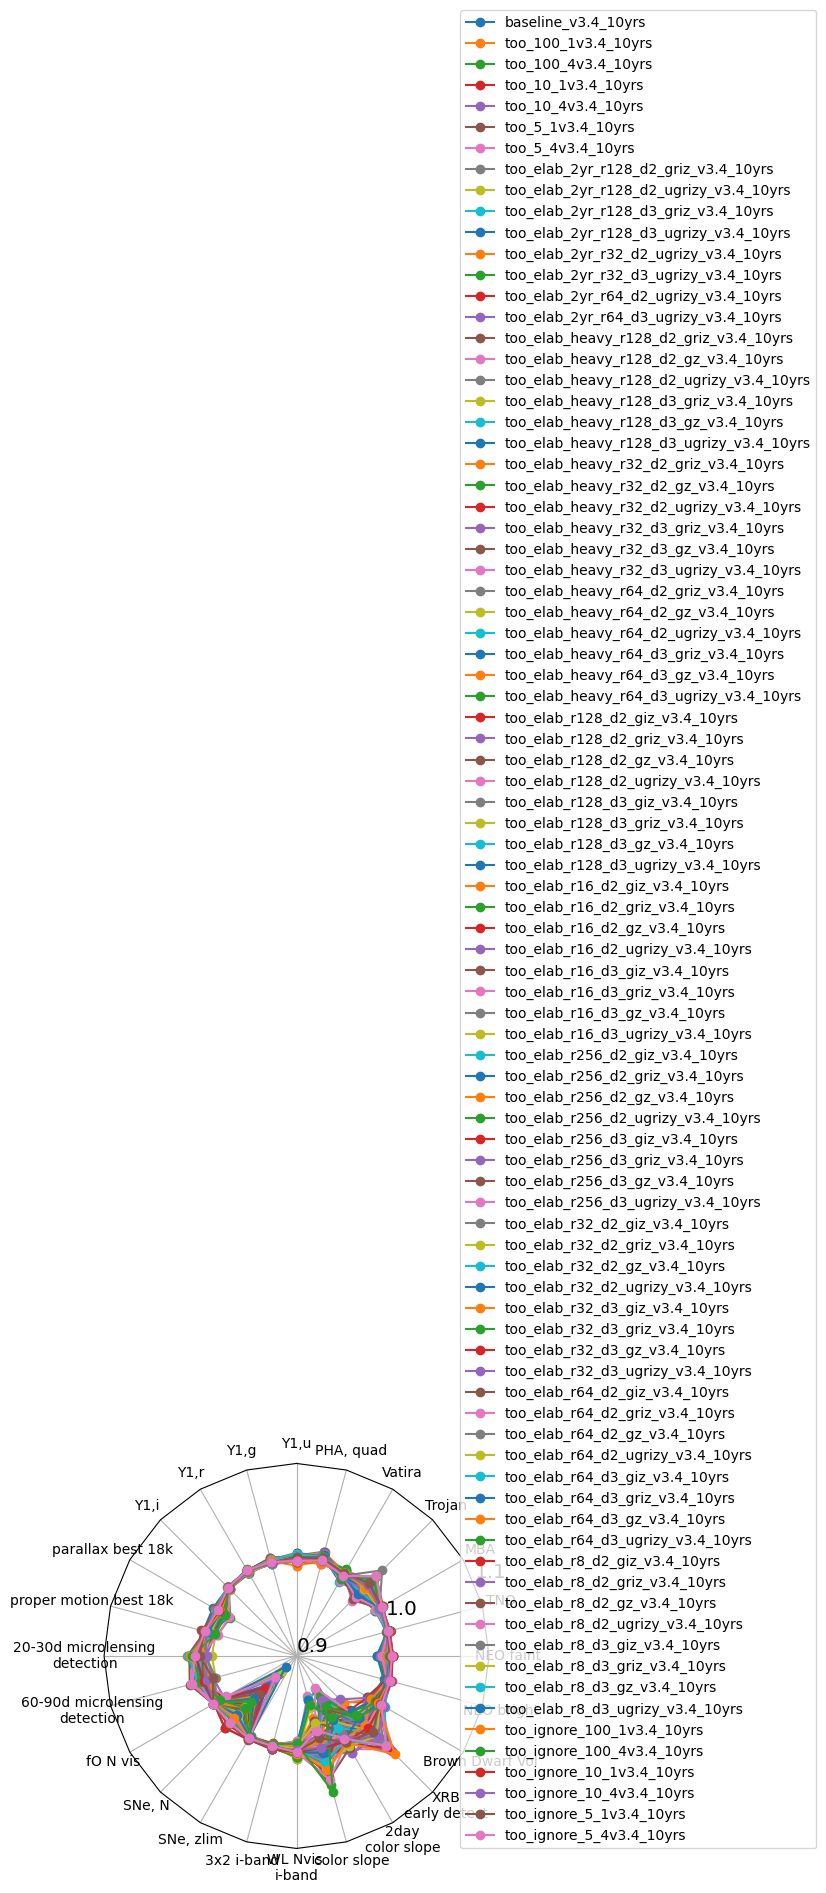

In [50]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'too_' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.85, 0))

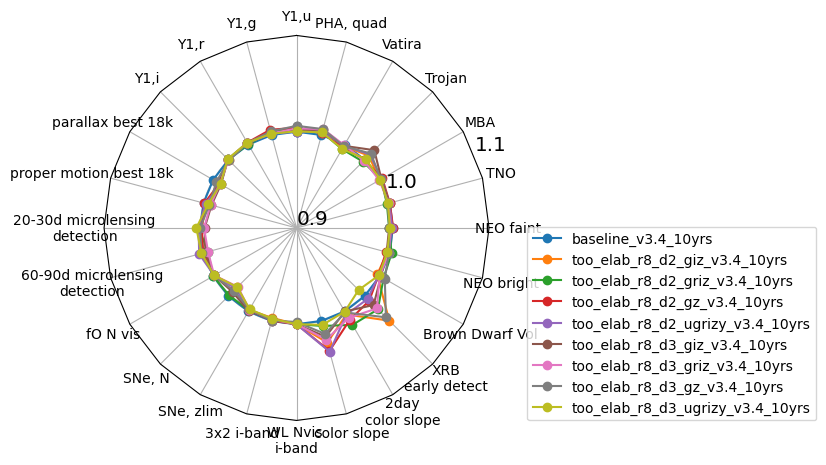

In [51]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'too_' in run and 'heavy' not in run and 'r8' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.85, 0))

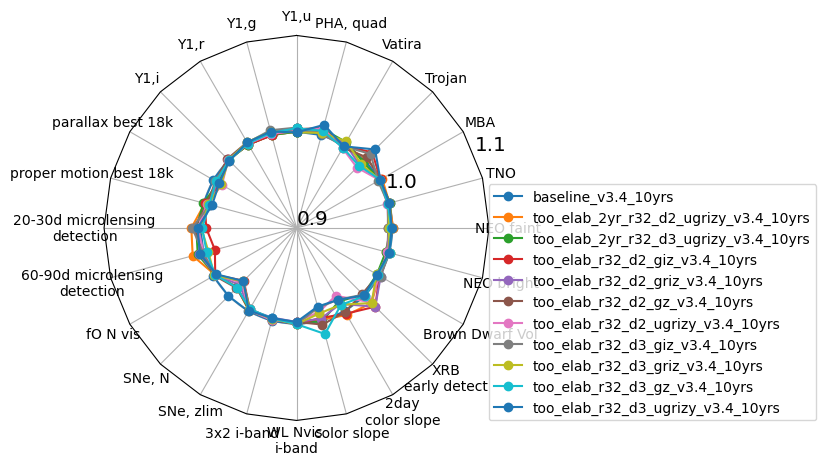

In [52]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'too_' in run and 'heavy' not in run and 'r32' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.85, 0))

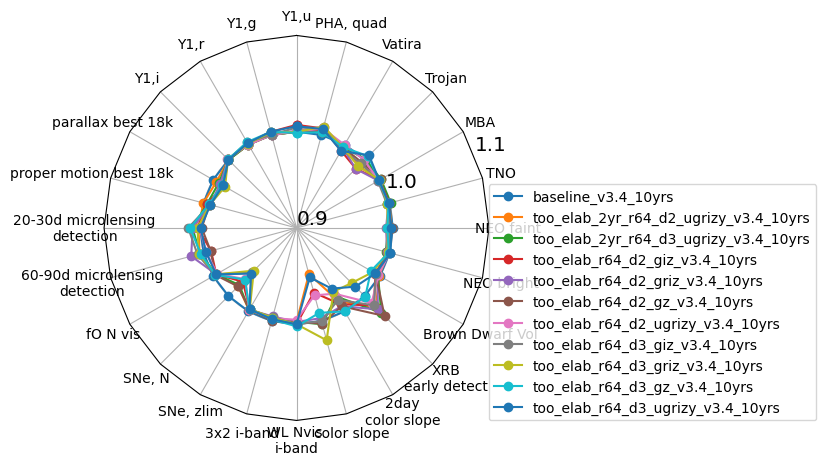

In [53]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'too_' in run and 'heavy' not in run and 'r64' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.85, 0))

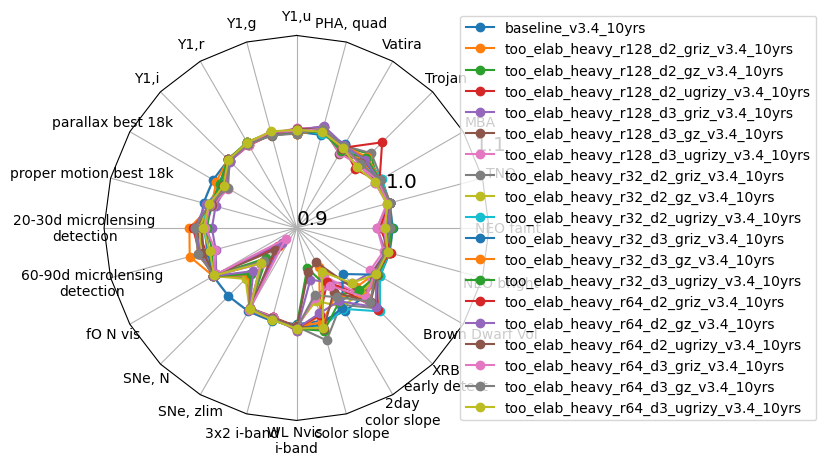

In [54]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'too_elab_heavy' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.85, 0))

In [55]:
data.loc[runs]['KNe single model']

KeyError: 'KNe single model'

In [ ]:
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(2.1, 0))

In [ ]:
runs = ['baseline_v3.4_10yrs'] + ['too_elab_r64_d3_ugrizy_v3.4_10yrs'] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.85, 0))

In [ ]:
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                 mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')#, invert_cols=['u', 'g', 'r', 'i', 'z', 'y'])
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.5, 0))

In [ ]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'no_magel' in run] 

ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [ ]:
runs = ['baseline_v3.4_10yrs', 'ddf_half_v3.4_10yrs'] 

ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

In [ ]:
ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.5], bbox_to_anchor=(1.65, 0))

In [ ]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' not in run]


ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [ ]:
ndata

In [ ]:
runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'ddf' in run and 'half' in run]


ndata = norm_df(ddf_data, runs, cols=ddf_data.columns.values.tolist(),
                invert_cols=None, mag_cols = mag_cols, norm_run='baseline_v3.4_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.5, 1.0, 1.5], bbox_to_anchor=(1.65, 0))

In [ ]:

sub_mag




In [ ]:
# Rough error bars from weather simulations

#col = data.columns[0]
for col in sub_mag.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_mag[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    
    label_add = ' (mag)'
    ax.set_ylabel('Median coadded' + col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


In [ ]:
[col for col in data_loaded.columns if 'MBA' in col and 'Inversion' in col and 'H = 18.0' in col]

In [ ]:

runs = ['baseline_v3.4_10yrs'] + [run for run in data.index if 'u_exp' in run]
fig, ax = plt.subplots()
ax.plot(data_loaded['FractionPop Lightcurve Inversion H = 18.000000 LightcurveInversionAsteroid MBA MoObjSlicer'].loc[runs],
       'ko')
ax.tick_params(axis='x', labelrotation = 90)


In [ ]:
[indx for indx in data_loaded.columns if 'Season' in indx and 'COSMOS' in indx]

In [ ]:
plt.plot(data_loaded['Mean DD:XMM_LSS Median Season Length all bands UserPointsSlicer'])

In [ ]:
plt.plot(data_loaded['Mean DD:COSMOS Median Season Length all bands UserPointsSlicer'])

In [ ]:
np.where(data_loaded['Mean DD:COSMOS Median Season Length all bands UserPointsSlicer'] > 190)

In [ ]:
data_loaded.index[50]

In [ ]:
# [indx for indx in data_loaded.columns if 'ToO' in indx]

In [ ]:
data_loaded['Identity Count night note like ToO, % UniSlicer']

In [ ]:

names = data_loaded.index.values[np.where(data_loaded['Identity Count night note like ToO, % UniSlicer'] > 0)[0]
]
names
rates = []
for name in data_loaded.index.values:
    if 'too' in name:
        if 'too_ignore' in name:
            rates.append(int(name.split('_')[2]))
        else:
            if '_r' in name:
                rates.append(int(name.split('_r')[1].split('_')[0].replace('r', '')))
            else:
                rates.append(int(name.split('_')[1]))
    else:
        rates.append(0)

In [ ]:
name

In [ ]:
fig, ax = plt.subplots()

scat = ax.scatter( data_loaded['Identity Count night note like ToO, % UniSlicer'],
         data_loaded['Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer'],
        c=rates)

ax.plot([0], data_loaded['Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer']['baseline_v3.4_10yrs'], 'ro')

ax.set_ylabel('N SNe < zlim, WFD')
ax.set_xlabel('N ToO visits')

cb = fig.colorbar(scat)
cb.set_label('ToO per year')

#locs = [name for name in data_loaded.index if 'too_1' in name or 'too_5' in name]

#ax.plot( data_loaded['Identity Count night note like ToO, % UniSlicer'].loc[locs],
#         data_loaded['Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer'].loc[locs],
#        'bo')

In [ ]:
fig, ax = plt.subplots()

comp = 'Median CoaddM5 g HealpixSlicer'

scat = ax.scatter( data_loaded['Identity Count night note like ToO, % UniSlicer'],
         data_loaded[comp],
        c=rates)

ax.plot([0], data_loaded[comp]['baseline_v3.4_10yrs'], 'ro')

ax.set_ylabel('Median coadded g depth (mag)')
ax.set_xlabel('N ToO visits')

cb = fig.colorbar(scat)
cb.set_label('ToO per year')


In [ ]:
fig, ax = plt.subplots()

ax.plot( data_loaded['Identity Count night note like ToO, % UniSlicer'],
         data_loaded['Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer']/500e3,
        'ko')

ax.plot([0], data_loaded['Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer']['baseline_v3.4_10yrs']/500e3, 'ro')

ax.set_ylabel('KNe ZTF simple fraction recovered')
ax.set_xlabel('N ToO visits')

In [ ]:
fig, ax = plt.subplots()

ax.plot( data_loaded['Identity Count night note like ToO, % UniSlicer'],
         data_loaded['Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer']/500e3,
        'ko')

ax.plot([0], data_loaded['Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer']['baseline_v3.4_10yrs']/500e3, 'ro')

ax.set_ylabel('KNe ZTF simple fraction recovered')
ax.set_xlabel('N ToO visits')

In [ ]:
data_loaded['Identity Count night note like ToO, % UniSlicer'].loc['too_100_4v3.4_10yrs']

In [ ]:
kne_data =  pd.read_hdf('summary_too.h5')


In [ ]:
kne_data.run_name

In [ ]:
indx = [i for i,name in enumerate(kne_data.run_name) if 'too_elab' in name and 'r64' in name and 'heavy' not in name]

In [ ]:
kne_data.iloc[indx]

In [ ]:
np.unique(kne_data.iloc[indx]["run_name"])

In [ ]:
identified = []
mean_no = []
nobs = kne_data["t1"] + kne_data["t2"] + kne_data["t4"] + kne_data["t24"] + kne_data["t48"]
for name in np.unique(kne_data.iloc[indx]["run_name"]):
    good = np.where((kne_data["run_name"].values == name) & (nobs.values > 0))[0]
    identified.append(np.mean(kne_data["presto_score_p"].values[good]))
    mean_no.append(nobs.values[good].mean())

In [ ]:
np.array(identified)

In [ ]:
mean_no

In [ ]:
fig, ax = plt.subplots()

for i, name in enumerate(np.unique(kne_data.iloc[indx]["run_name"])):

    ax.scatter(mean_no[i], identified[i], label=name.replace('too_elab_', '').replace('_v3.4_10yrs', ''))
ax.set_xlabel('Mean number of visits per ToO')
ax.set_ylabel('Fraction of ToOs classified')
ax.set_title('ToOs with some observations')
ax.legend()

In [ ]:
plt.plot(data["KNe Score, P"]/10e3, data["KNe single model"]/500e3, 'ko', alpha=.2, label='v3.4')

b_indx = np.where(data.index == 'baseline_v3.4_10yrs')[0]

plt.plot(data["KNe Score, P"].values[b_indx]/10e3, data["KNe single model"].values[b_indx]/500e3,
         'ro', label='baseline_v3.4', alpha=0.5)
plt.xlabel('KNe Score, P  (Fraction Classified)')
plt.ylabel('KNe single model (Fraction Classified)')
plt.title('v3.4 runs + previous baselines')

runs = [run for run in data.index if 'uniform' in run and 'half' not in run] 

plt.plot(data["KNe Score, P"].loc[runs]/10e3, data["KNe single model"].loc[runs]/500e3,
         'bo', label='uniform rolling', alpha=0.5)

runs = [run for run in data.index if 'v3.4' not in run ] 

plt.plot(data["KNe Score, P"].loc[runs]/10e3, data["KNe single model"].loc[runs]/500e3,
         'yo', label='Previous Baselines', alpha=0.5)

runs = [run for run in data.index if 'v3.3' in run ] 

plt.plot(data["KNe Score, P"].loc[runs]/10e3, data["KNe single model"].loc[runs]/500e3,
         'go', label='baseline_v3.3', alpha=0.5)

leg = plt.legend()

In [ ]:
data["KNe Score, S"] = data_loaded["Sum PrestoKNe_score_s UserPointsSlicer"]

plt.plot(data["KNe Score, S"], data["KNe single model"]/500e3, 'ko', alpha=.2, label='v3.4')

b_indx = np.where(data.index == 'baseline_v3.4_10yrs')[0]

plt.plot(data["KNe Score, S"].values[b_indx], data["KNe single model"].values[b_indx]/500e3,
         'ro', label='baseline_v3.4', alpha=0.5)
plt.xlabel('KNe Score, S')
plt.ylabel('KNe single model')
plt.title('v3.4 runs + previous baselines')

runs = [run for run in data.index if 'uniform' in run and 'half' not in run] 

plt.plot(data["KNe Score, S"].loc[runs], data["KNe single model"].loc[runs]/500e3,
         'bo', label='uniform rolling', alpha=0.5)

runs = [run for run in data.index if 'v3.4' not in run ] 

plt.plot(data["KNe Score, S"].loc[runs], data["KNe single model"].loc[runs]/500e3,
         'yo', label='Previous Baselines', alpha=0.5)

runs = [run for run in data.index if 'v3.3' in run ] 

plt.plot(data["KNe Score, S"].loc[runs], data["KNe single model"].loc[runs]/500e3,
         'go', label='baseline_v3.3', alpha=0.5)

leg = plt.legend()

In [ ]:
data["KNe Score, P"].loc['no_long_v3.4_10yrs'], data["KNe Score, P"].loc['baseline_v3.4_10yrs']

In [ ]:
indx = np.where(data["KNe single model"]/500e3 < .011) 
indx = np.where(data["KNe Score, P"] < 220) 

data_loaded.index[indx]

In [ ]:
from scipy.stats import pearsonr


In [ ]:
good = np.isfinite(data["KNe Score, P"]*data["KNe single model"])
pearsonr(data["KNe Score, P"].values[good], data["KNe single model"].values[good])

In [ ]:
good = np.isfinite(data["KNe ZTF simple"]*data["KNe single model"])
pearsonr(data["KNe ZTF simple"].values[good], data["KNe single model"].values[good])

In [ ]:
data_loaded['Identity Counts_long UniSlicer'].loc['baseline_v3.0_10yrs']

In [ ]:
data_loaded['Sum ColorSlope visitExposureTime > 19 HealpixSlicer'].loc['baseline_v3.4_10yrs']

In [ ]:
data_loaded['Sum ColorSlope visitExposureTime > 19 HealpixSlicer'].loc['no_long_v3.4_10yrs']

In [ ]:
data_loaded['Sum ColorSlope visitExposureTime > 19 HealpixSlicer'].loc['all_long_v3.4_10yrs']

In [ ]:
data_loaded['Sum ColorSlope visitExposureTime > 19 HealpixSlicer'].loc['roll_uniform_mjdp0_v3.4_10yrs']

In [ ]:
data_loaded['Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer'].loc['baseline_v3.4_10yrs']

In [ ]:
data_loaded['Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer'].loc['noroll_mjdp0_v3.4_10yrs']

In [ ]:
data_loaded['Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer'].loc['roll_uniform_mjdp180_v3.4_10yrs']

In [ ]:
runs = [run for run in data.index if 'uniform' in run and 'half' not in run] 
ack = data_loaded['Sum ColorSlope2Night visitExposureTime > 19 HealpixSlicer'].loc[runs]
(ack.max() - ack.min())/ack.max()